

# Comprehensive COP Twitter Analysis

A detailed analysis of Conference of the Parties (COP) Twitter data with sentiment analysis, engagement metrics, temporal patterns, and topic clustering.


In [ ]:


# --- Import Libraries -----------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import warnings
import calendar
from datetime import datetime
from scipy import stats

# Text analysis and machine learning libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:


# --- Visualization and Display Setup --------------------------------------------
# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Create a custom visualization style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.figsize'] = (12, 8)

# Custom color palette
custom_palette = sns.color_palette("viridis", 10)
sns.set_palette(custom_palette)
sns.set_style('whitegrid', {'grid.linestyle': '--', 'grid.alpha': 0.6})

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# Download required NLTK resources
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [ ]:


# --- Helper Functions ----------------------------------------------------------
def format_plot(ax, title, xlabel=None, ylabel=None, legend_title=None,
                xtick_rotation=0, tight=True, grid=True):
    """Apply consistent formatting to matplotlib plots"""
    ax.set_title(title, fontweight='bold', pad=15)

    if xlabel:
        ax.set_xlabel(xlabel, fontweight='bold', labelpad=10)
    if ylabel:
        ax.set_ylabel(ylabel, fontweight='bold', labelpad=10)

    if legend_title and ax.get_legend():
        ax.legend(title=legend_title, frameon=True, framealpha=0.9)

    if grid:
        ax.grid(alpha=0.3, linestyle='--')

    plt.xticks(rotation=xtick_rotation)

    if tight:
        plt.tight_layout()

    return ax

def generate_wordcloud(text_series, title="Word Cloud of Tweets", max_words=200):
    """Generate and display a word cloud from a series of texts"""
    # Combine all text
    text = " ".join(text_series)
    word_count = len(text.split())
    print(f"There are {word_count:,} words in the combined texts.")

    # Define stopwords
    stop_words = set(STOPWORDS)
    stop_words.update(['https', 'co', 'etc', 'rt', 'amp', 'the', 'and', 'to', 'of', 'a', 'in', 'is', 'for', 'that', 'on'])

    # Generate wordcloud
    wordcloud = WordCloud(
        stopwords=stop_words,
        max_font_size=100,
        random_state=42,
        width=1600,
        height=800,
        min_font_size=6,
        max_words=max_words,
        background_color='white',
        colormap='viridis'
    ).generate(text)

    # Display the wordcloud
    plt.figure(figsize=(16, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    return wordcloud

def analyze_engagement(df, metric, title_prefix=""):
    """Analyze and visualize an engagement metric"""
    print(f"\n{title_prefix} {metric.replace('_', ' ').title()} Statistics:")
    print(f"- Highest: {df[metric].max():,.0f}")
    print(f"- Lowest: {df[metric].min():,.0f}")
    print(f"- Average: {df[metric].mean():,.1f}")
    print(f"- Median: {df[metric].median():,.1f}")

    # Get top 10 entries
    top_10 = df.sort_values(by=metric, ascending=False).head(10).copy()
    top_10['rank'] = [f"Top {i+1}" for i in range(len(top_10))]

    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.barplot(x='rank', y=metric, data=top_10, palette='plasma', ax=ax)

    # Add annotations
    for p in ax.patches:
        ax.annotate(f'{p.get_height():,.0f}',
                   (p.get_x() + p.get_width()/2., p.get_height() + 0.1),
                   ha='center')

    plt.title(f'Top 10 Tweets by {metric.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    plt.ylabel(f'{metric.replace("_", " ").title()}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Show top example with sentiment
    top_example = top_10.iloc[0]
    print(f"\nTop {metric.replace('_', ' ')} example:")
    print(f"- Sentiment: {top_example['sentiment']}")
    print(f"- Aspect: {top_example['aspect']}")
    print(f"- Text: {top_example['cleaned_text'][:200]}..." if len(top_example['cleaned_text']) > 200
          else f"- Text: {top_example['cleaned_text']}")

    return top_10

def generate_ngrams(text_series, n=2, top_n=20):
    """Generate and visualize top n-grams"""
    # Join all text
    text = ' '.join(text_series)

    # Create n-gram vectorizer
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngram_counts = vectorizer.fit_transform([text])

    # Get top n-grams
    ngrams = vectorizer.get_feature_names_out()
    count_values = ngram_counts.toarray().sum(axis=0)

    # Create DataFrame with n-grams and counts
    ngram_df = pd.DataFrame({'ngram': ngrams, 'count': count_values})
    ngram_df = ngram_df.sort_values('count', ascending=False).head(top_n)

    # Visualize
    plt.figure(figsize=(12, 6))
    sns.barplot(y='ngram', x='count', data=ngram_df, palette='viridis')
    plt.title(f'Top {top_n} {n}-grams in COP Tweets', fontweight='bold')
    plt.xlabel('Count')
    plt.ylabel(f'{n}-gram')
    plt.tight_layout()
    plt.show()

    return ngram_df

def get_top_terms_per_cluster(kmeans, tfidf_vectorizer, n_terms=10):
    """Extract the top n terms for each cluster"""
    # Get cluster centers
    centers = kmeans.cluster_centers_
    terms = tfidf_vectorizer.get_feature_names_out()

    # For each cluster, get the top terms
    top_terms = {}
    for i in range(centers.shape[0]):
        # Get indices of terms with highest TF-IDF scores for this cluster
        indices = centers[i].argsort()[::-1][:n_terms]
        top_terms[i] = [terms[j] for j in indices]

    return top_terms

def plot_enhanced_correlation(df, metrics, title="Enhanced Correlation Analysis"):
    """
    Creates an enhanced correlation matrix visualization with additional statistics
    """
    # Calculate correlation matrix
    corr_matrix = df[metrics].corr()

    # Create a figure with gridspec for custom layout
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[3, 1])

    # Correlation heatmap (upper left)
    ax_heatmap = plt.subplot(gs[0, 0])
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap=cmap, fmt='.2f',
                linewidths=0.5, vmin=-1, vmax=1, square=True, cbar_kws={"shrink": .8},
                annot_kws={"size": 10})

    plt.title('Correlation Matrix', fontsize=14, fontweight='bold')

    # Variable distributions (diagonal plots)
    ax_dist = plt.subplot(gs[0, 1])

    # Create a multi-panel KDE plot for the distributions
    for i, metric in enumerate(metrics):
        sns.kdeplot(df[metric], ax=ax_dist, label=metric.replace('_', ' ').title())

    ax_dist.set_title('Variable Distributions', fontsize=12, fontweight='bold')
    ax_dist.legend(loc='upper right')
    ax_dist.set_xlabel('Value (Standardized)')
    ax_dist.set_ylabel('Density')

    # Standardize the data for comparing distributions
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df[metrics]),
        columns=metrics
    )

    # Scatter plot matrix with regression lines (bottom left)
    ax_scatter = plt.subplot(gs[1, 0])

    # Create a flattened version for pairwise comparisons
    df_flat = pd.DataFrame({
        'Variable': np.repeat(metrics, len(df)),
        'Value': np.concatenate([df_scaled[col].values for col in metrics]),
        'Category': np.tile(np.arange(len(df)), len(metrics))
    })

    sns.boxplot(x='Variable', y='Value', data=df_flat, ax=ax_scatter, palette='viridis')
    ax_scatter.set_title('Comparison of Distributions', fontsize=12, fontweight='bold')
    ax_scatter.set_xlabel('')
    ax_scatter.set_ylabel('Standardized Value')
    ax_scatter.set_xticklabels([x.replace('_', ' ').title() for x in metrics], rotation=45)

    # Summary statistics table (bottom right)
    ax_stats = plt.subplot(gs[1, 1])
    ax_stats.axis('off')

    # Calculate summary statistics
    stats_df = df[metrics].describe().T[['mean', 'std', 'min', 'max']]
    stats_df['cv'] = stats_df['std'] / stats_df['mean']  # Coefficient of variation

    # Format the table data
    cell_text = []
    for index, row in stats_df.iterrows():
        cell_text.append([
            index.replace('_', ' ').title(),
            f"{row['mean']:.2f}",
            f"{row['std']:.2f}",
            f"{row['cv']:.2f}",
        ])

    # Create the table
    table = ax_stats.table(
        cellText=cell_text,
        colLabels=['Metric', 'Mean', 'Std Dev', 'CV'],
        loc='center',
        cellLoc='center'
    )

    # Adjust table style
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)

    ax_stats.set_title('Summary Statistics', fontsize=12, fontweight='bold')

    plt.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    # Print additional statistical insights
    print("\nStatistical Insights:")

    # Check for outliers using Z-score
    for metric in metrics:
        z_scores = np.abs(stats.zscore(df[metric]))
        outliers = len(z_scores[z_scores > 3])
        print(f"- {metric.replace('_', ' ').title()}: {outliers} outliers detected (Z-score > 3)")

    # Check for the strongest correlations
    corr_values = corr_matrix.unstack()
    # Remove self-correlations and duplicates
    corr_values = corr_values[corr_values < 1.0]

    strongest_corr = corr_values.abs().nlargest(3)
    print("\nStrongest correlations:")
    for idx, corr_val in strongest_corr.items():
        var1, var2 = idx
        print(f"- {var1.replace('_', ' ').title()} and {var2.replace('_', ' ').title()}: {corr_val:.3f}")

    return corr_matrix

def create_aspect_sentiment_heatmap(df):
    """Creates a heatmap showing sentiment distribution across aspects"""
    # Create crosstab of aspect and sentiment
    aspect_sentiment = pd.crosstab(df['aspect'], df['sentiment'], normalize='index') * 100

    # Sort aspects by overall positivity
    if 'Positive' in aspect_sentiment.columns and 'Negative' in aspect_sentiment.columns:
        aspect_sentiment['positivity_score'] = aspect_sentiment['Positive'] - aspect_sentiment['Negative']
        aspect_sentiment = aspect_sentiment.sort_values('positivity_score', ascending=False)
        aspect_sentiment = aspect_sentiment.drop('positivity_score', axis=1)

    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(aspect_sentiment, annot=True, fmt='.1f', cmap='RdYlGn')
    plt.title('Sentiment Distribution Across Aspects (%)', fontweight='bold', fontsize=14)
    plt.xlabel('Sentiment', fontsize=12)
    plt.ylabel('Aspect', fontsize=12)
    plt.tight_layout()
    plt.show()

    return aspect_sentiment

In [ ]:


# --- Data Loading and Initial Processing -----------------------------------------
print("=" * 80)
print("COP TWITTER ANALYSIS".center(80))
print("=" * 80)
print("\nLoading and preprocessing data...")

# Load data
df = pd.read_csv('analysis_results_with_sentiments-3.csv')

# Display basic information in a structured format
print("\n" + "=" * 50)
print("DATASET OVERVIEW")
print("=" * 50)
print(f"Total tweets: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]:,}")

# Check for missing values
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage': missing_percent
})
if missing_summary['Missing Values'].sum() > 0:
    print("\nMissing Value Analysis:")
    print(missing_summary[missing_summary['Missing Values'] > 0].sort_values('Missing Values', ascending=False))
else:
    print("\nNo missing values found in the dataset.")

                              COP TWITTER ANALYSIS                              

Loading and preprocessing data...

DATASET OVERVIEW
Total tweets: 182,347
Total features: 16

Missing Value Analysis:
                   Missing Values  Percentage
text_tagged_users          112392   61.636331
text_tags                   36058   19.774386
cleaned_text                10345    5.673249
aspect                       3279    1.798220
text_lang                    2013    1.103939
sentiment                    1820    0.998097
view_count                    679    0.372367


In [ ]:


# --- Data Cleaning and Feature Engineering ---------------------------------------
print("\nCleaning data and creating features...")

# Convert datetime and create time-based features
df['created_time'] = pd.to_datetime(df['created_time'])
print(f"Time range: {df['created_time'].min()} to {df['created_time'].max()}")

# Create time-based features for analysis
df['date_'] = df['created_time'].dt.date
df['year'] = df['created_time'].dt.year
df['month'] = df['created_time'].dt.month
df['day'] = df['created_time'].dt.day
df['year/month'] = df['created_time'].dt.strftime('%Y-%m')
df['day_of_week'] = df['created_time'].dt.day_name()
df['hour_of_day'] = df['created_time'].dt.hour

# Order days correctly for visualizations
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)



Cleaning data and creating features...
Time range: 2024-10-11 00:03:48 to 2024-12-10 23:59:29


In [ ]:

# Anonymize usernames more efficiently
if 'author_username' in df.columns:
    # Convert categorical codes to a pandas Series before applying map
    codes = pd.Categorical(df['author_username']).codes
    df['author_username'] = pd.Series(codes).map(lambda x: f'author_{x+1}').values

In [ ]:
# Fill any missing text values
df['cleaned_text'] = df['cleaned_text'].astype(str).fillna('')

# Calculate word count more efficiently
df['length_words'] = df['cleaned_text'].apply(lambda x: len(word_tokenize(x)))

# Check for duplicate tweets
duplicates = df.duplicated(subset=['cleaned_text']).sum()
print(f"Found {duplicates} duplicate tweets ({duplicates/len(df)*100:.1f}% of the dataset)")

# Convert sentiment to numeric for correlation analysis
sentiment_mapping = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
df['sentiment_score'] = df['sentiment'].map(sentiment_mapping)

Found 39287 duplicate tweets (21.5% of the dataset)



SENTIMENT ANALYSIS
Sentiment Distribution:
- Positive: 40.1%
- Neutral: 32.0%
- Negative: 27.9%


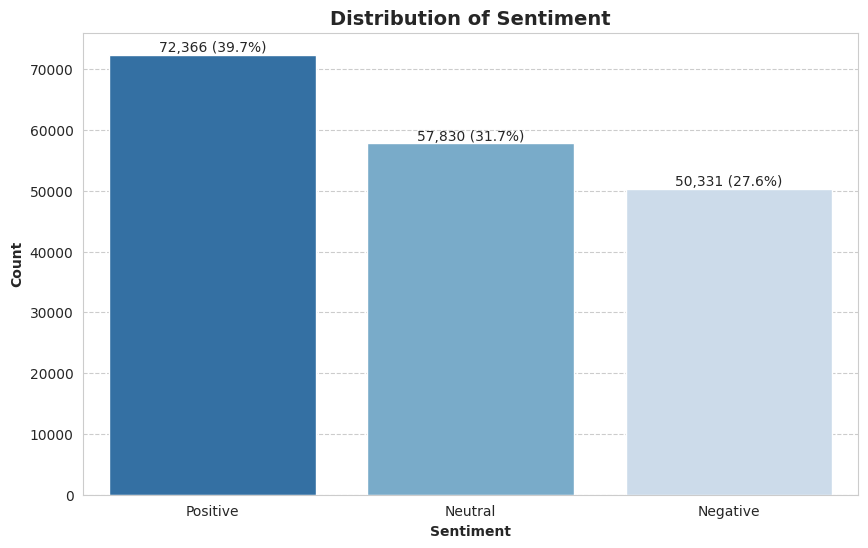

In [ ]:


# --- Sentiment Analysis ---------------------------------------------------------
print("\n" + "=" * 50)
print("SENTIMENT ANALYSIS")
print("=" * 50)

# Create a summary of sentiment distribution
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']
sentiment_percentage = df['sentiment'].value_counts(normalize=True) * 100

print("Sentiment Distribution:")
for sentiment, percentage in sentiment_percentage.items():
    print(f"- {sentiment}: {percentage:.1f}%")

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='sentiment', y='count', data=sentiment_counts, palette='Blues_r')
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f} ({p.get_height()/df.shape[0]*100:.1f}%)',
                (p.get_x() + p.get_width()/2., p.get_height() + 10),
                ha='center', va='bottom')
plt.title('Distribution of Sentiment', weight='bold')
plt.ylabel('Count', fontsize=10, weight='bold')
plt.xlabel('Sentiment', fontsize=10, weight='bold')
plt.show()



ASPECT-BASED ANALYSIS
Top 15 Aspects in the Dataset:
- Climate Action and Policy: 46,823 tweets (25.7%)
- Public Awareness and Activism: 42,596 tweets (23.4%)
- Technology and Innovation: 22,131 tweets (12.1%)
- Biodiversity and Ecosystems: 17,501 tweets (9.6%)
- Global Cooperation: 14,284 tweets (7.8%)
- Climate Finance: 13,938 tweets (7.6%)
- Adaptation and Resilience: 5,474 tweets (3.0%)
- Equity and Justice: 4,614 tweets (2.5%)
- Public Health: 3,900 tweets (2.1%)
- Corporate and Private Sector Role: 3,658 tweets (2.0%)
- Green Jobs and Economic Transition: 1,208 tweets (0.7%)
- Loss and Damage: 1,137 tweets (0.6%)
- Carbon Markets and Trading: 1,031 tweets (0.6%)
- Monitoring, Reporting, and Verification (MRV): 387 tweets (0.2%)
- Geoengineering and Controversial Solutions: 386 tweets (0.2%)


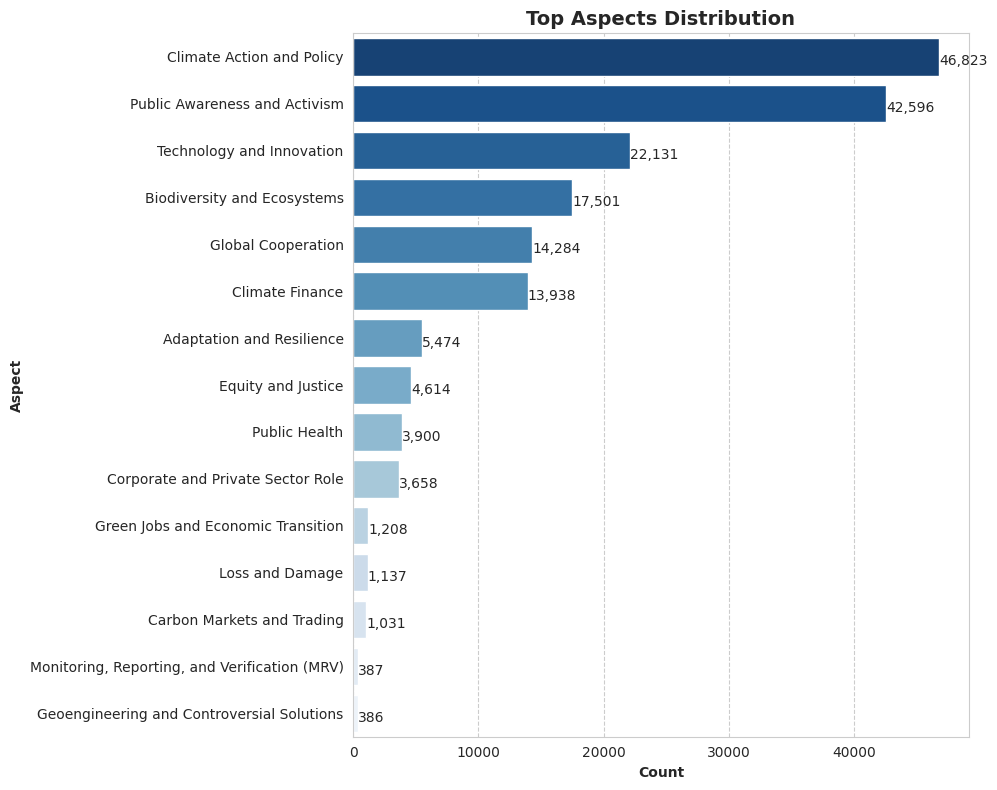

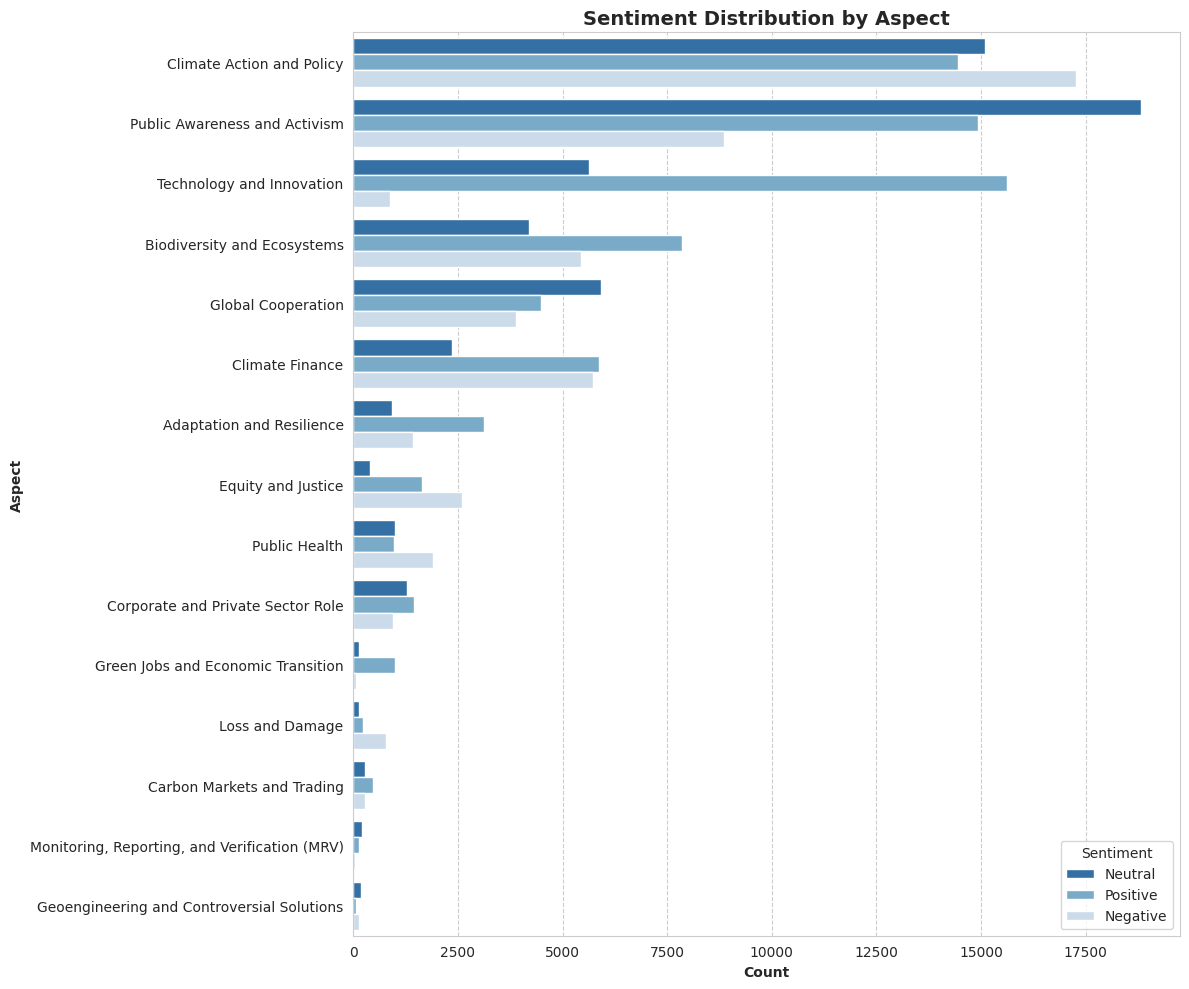

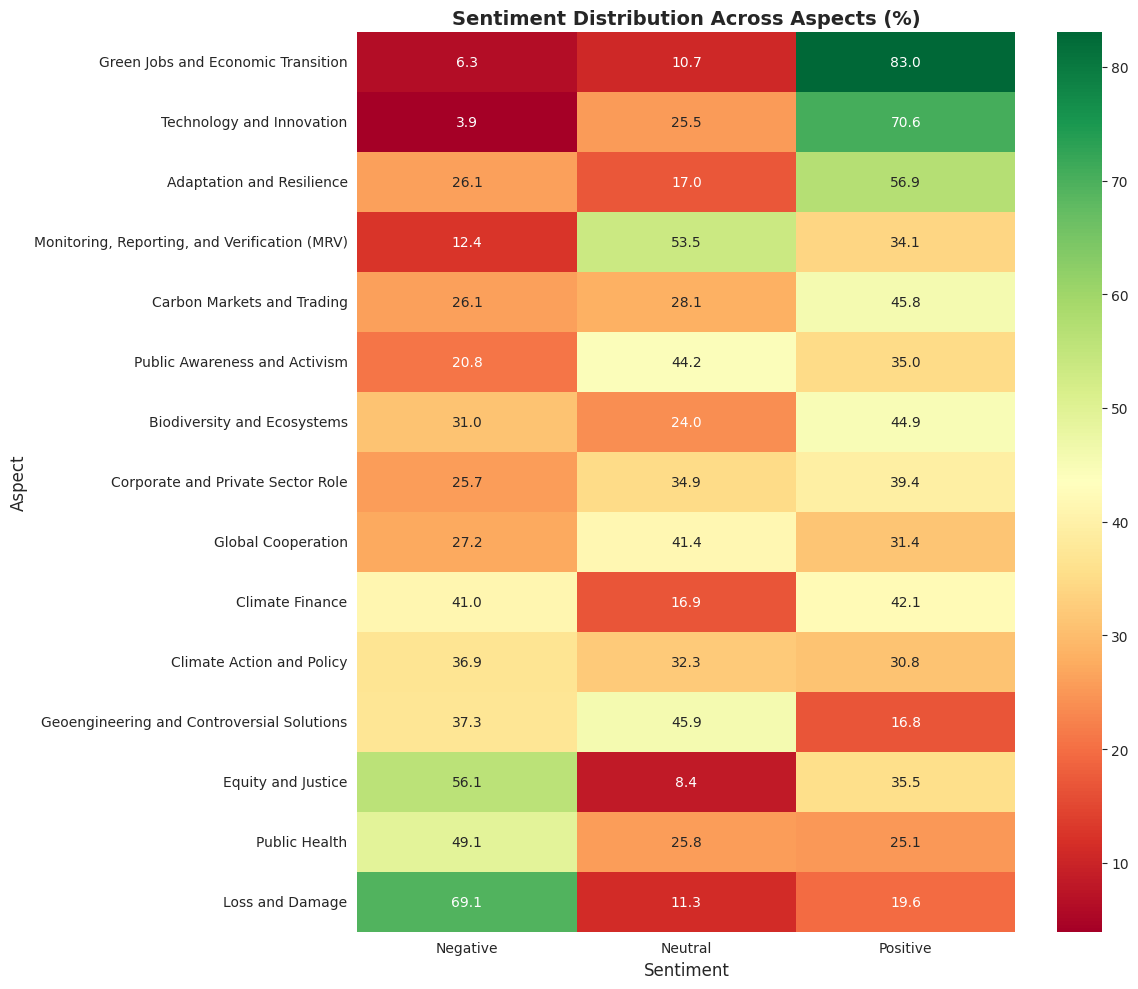

In [ ]:

# --- Aspect-Based Analysis ------------------------------------------------------
print("\n" + "=" * 50)
print("ASPECT-BASED ANALYSIS")
print("=" * 50)

# Visualize aspects more efficiently
aspect_counts = df['aspect'].value_counts()
top_n_aspects = min(15, len(aspect_counts))
print(f"Top {top_n_aspects} Aspects in the Dataset:")
for aspect, count in aspect_counts.head(top_n_aspects).items():
    print(f"- {aspect}: {count:,} tweets ({count/len(df)*100:.1f}%)")

plt.figure(figsize=(10, 8))
ax = sns.barplot(y=aspect_counts.index[:top_n_aspects], x=aspect_counts.values[:top_n_aspects], palette='Blues_r')
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.0f}',
                (p.get_width() + 0.1, p.get_y() + 0.5),
                va='center')
plt.title('Top Aspects Distribution', weight='bold')
plt.xlabel('Count', fontsize=10, weight='bold')
plt.ylabel('Aspect', fontsize=10, weight='bold')
plt.tight_layout()
plt.show()

# Aspect with sentiment breakdown
plt.figure(figsize=(12, 10))
aspect_order = aspect_counts.index[:top_n_aspects]
ax = sns.countplot(y='aspect', data=df[df['aspect'].isin(aspect_order)],
                  hue='sentiment', palette='Blues_r', order=aspect_order)
plt.title('Sentiment Distribution by Aspect', weight='bold')
plt.ylabel('Aspect', fontsize=10, weight='bold')
plt.xlabel('Count', fontsize=10, weight='bold')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

# Create aspect-sentiment heatmap
aspect_sentiment_heatmap = create_aspect_sentiment_heatmap(df[df['aspect'].isin(aspect_order)])


TWEET LENGTH ANALYSIS
Tweet Length Statistics:
- Maximum: 1303 words
- Minimum: 1 words
- Average: 25.1 words
- Median: 24.0 words
- Standard Deviation: 22.5 words


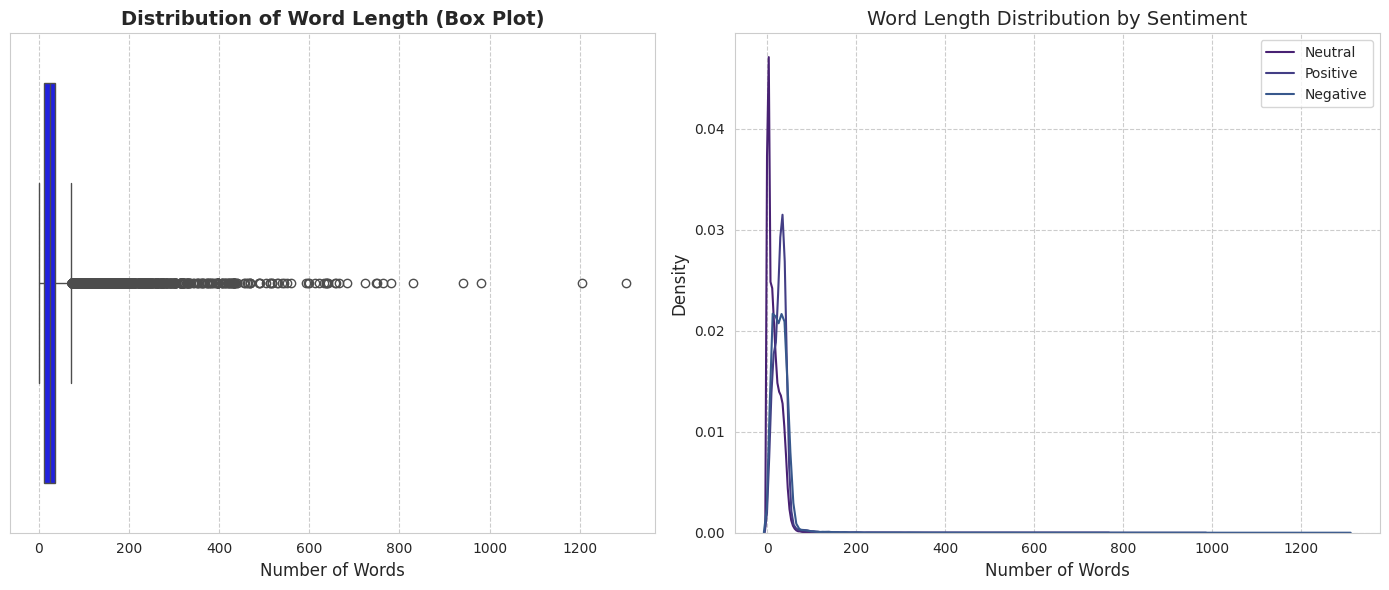

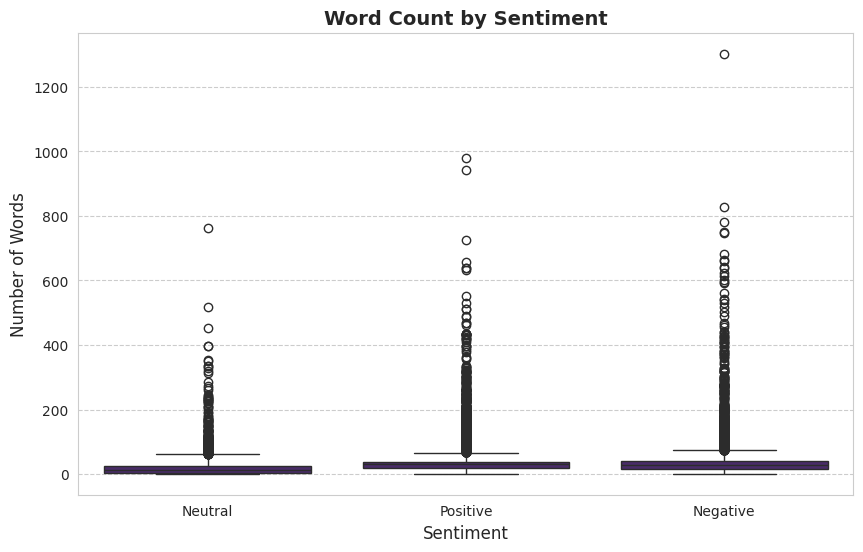

In [ ]:


# --- Tweet Length Analysis ------------------------------------------------------
print("\n" + "=" * 50)
print("TWEET LENGTH ANALYSIS")
print("=" * 50)

# Summarize tweet length statistics
length_stats = {
    'Maximum': df['length_words'].max(),
    'Minimum': df['length_words'].min(),
    'Average': round(df['length_words'].mean(), 1),
    'Median': df['length_words'].median(),
    'Standard Deviation': round(df['length_words'].std(), 1)
}
print("Tweet Length Statistics:")
for stat, value in length_stats.items():
    print(f"- {stat}: {value} words")

# Visualize tweet length distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Box plot
sns.boxplot(x=df['length_words'], ax=ax1, color='blue')
ax1.set_title('Distribution of Word Length (Box Plot)', weight='bold')
ax1.set_xlabel('Number of Words')

# Kernel density plot by sentiment
for sentiment in df['sentiment'].unique():
    sns.kdeplot(df[df['sentiment'] == sentiment]['length_words'],
                ax=ax2,
                label=sentiment)
ax2.set_title("Word Length Distribution by Sentiment")
ax2.set_xlabel('Number of Words')
ax2.legend()

plt.tight_layout()
plt.show()

# Words vs. sentiment relationship
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='length_words', data=df)
plt.title('Word Count by Sentiment', weight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.show()



ENGAGEMENT ANALYSIS

 Retweet Count Statistics:
- Highest: 13,889
- Lowest: 0
- Average: 3.5
- Median: 0.0


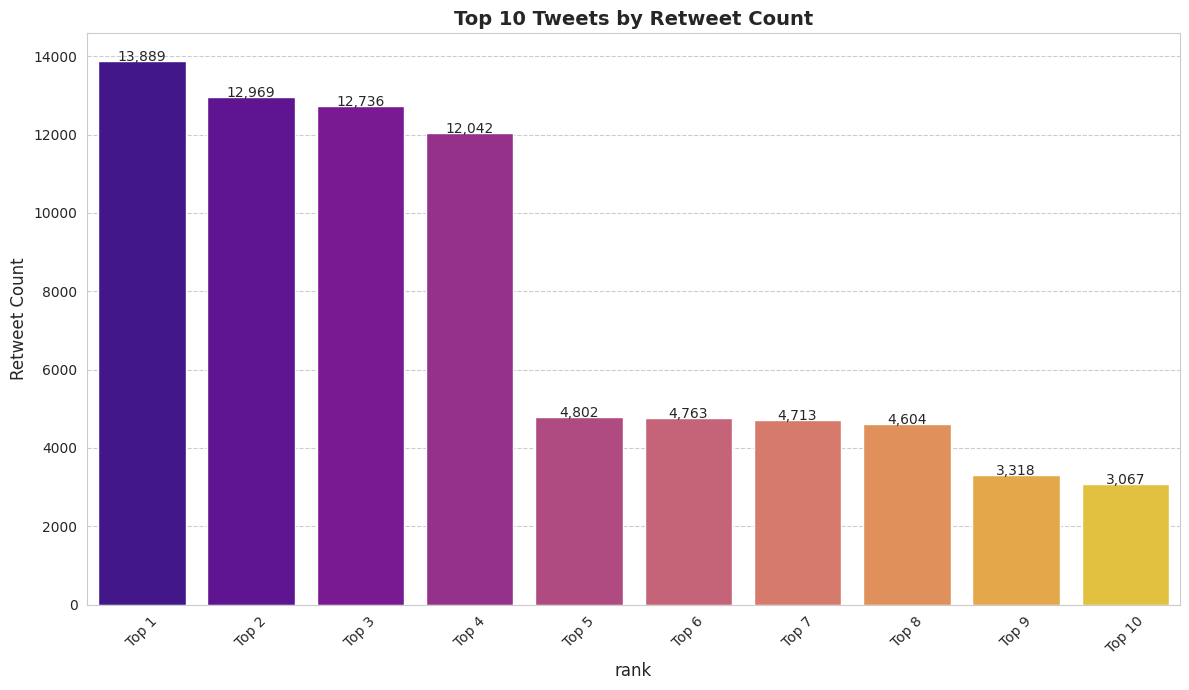


Top retweet count example:
- Sentiment: Negative
- Aspect: Public Health
- Text: Countless Americans are endangered now on a scale and intensity almost unheard of in modern America. Our first responsibility is to protect these people and resist these forces.

 Favorite Count Statistics:
- Highest: 216,915
- Lowest: 0
- Average: 12.9
- Median: 1.0


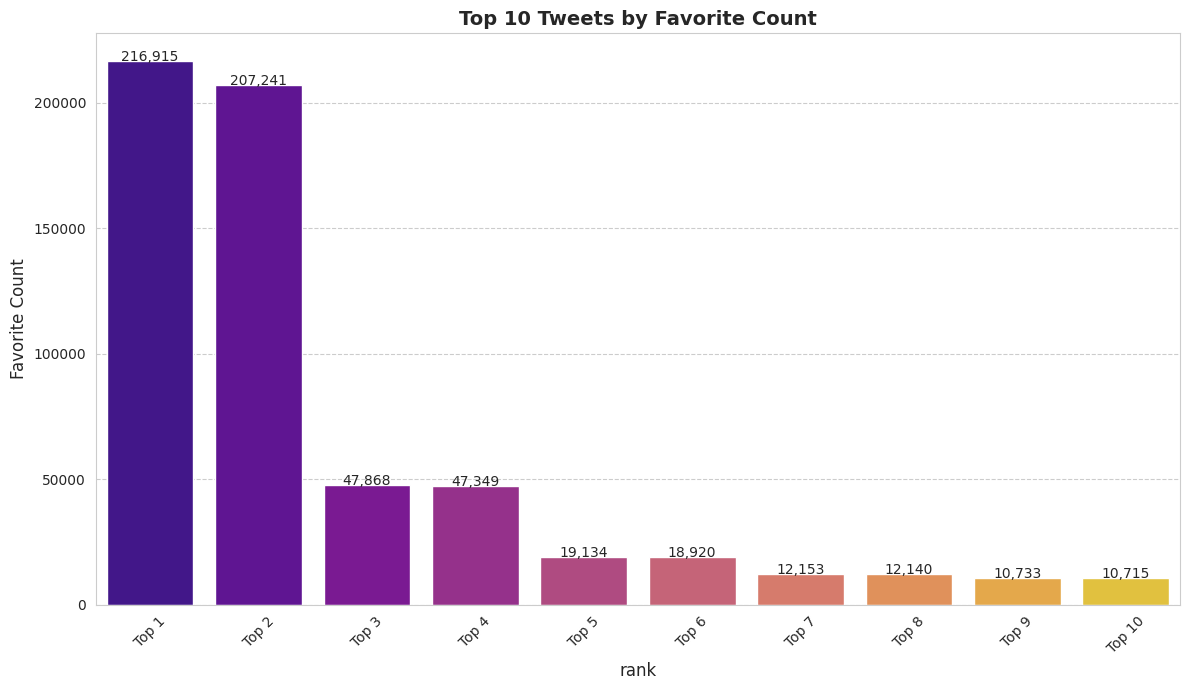


Top favorite count example:
- Sentiment: Positive
- Aspect: Biodiversity and Ecosystems
- Text: Zoos are good. They do an enormous amount of conservation work and they’re very dedicated to protecting endangered species. A lot of the animals they care for can’t survive on their own. It’s also goo...

 Reply Count Statistics:
- Highest: 13,545
- Lowest: 0
- Average: 1.1
- Median: 0.0


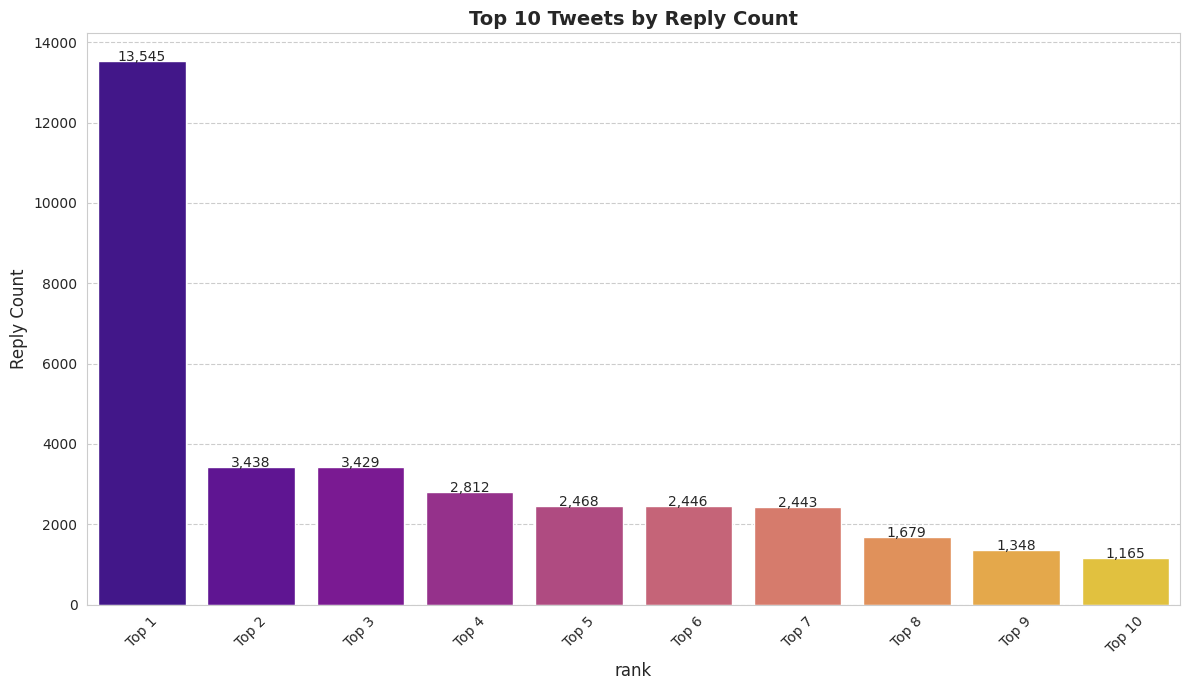


Top reply count example:
- Sentiment: Negative
- Aspect: Public Health
- Text: Countless Americans are endangered now on a scale and intensity almost unheard of in modern America. Our first responsibility is to protect these people and resist these forces.

 View Count Statistics:
- Highest: 9,960,471
- Lowest: 1
- Average: 976.0
- Median: 42.0


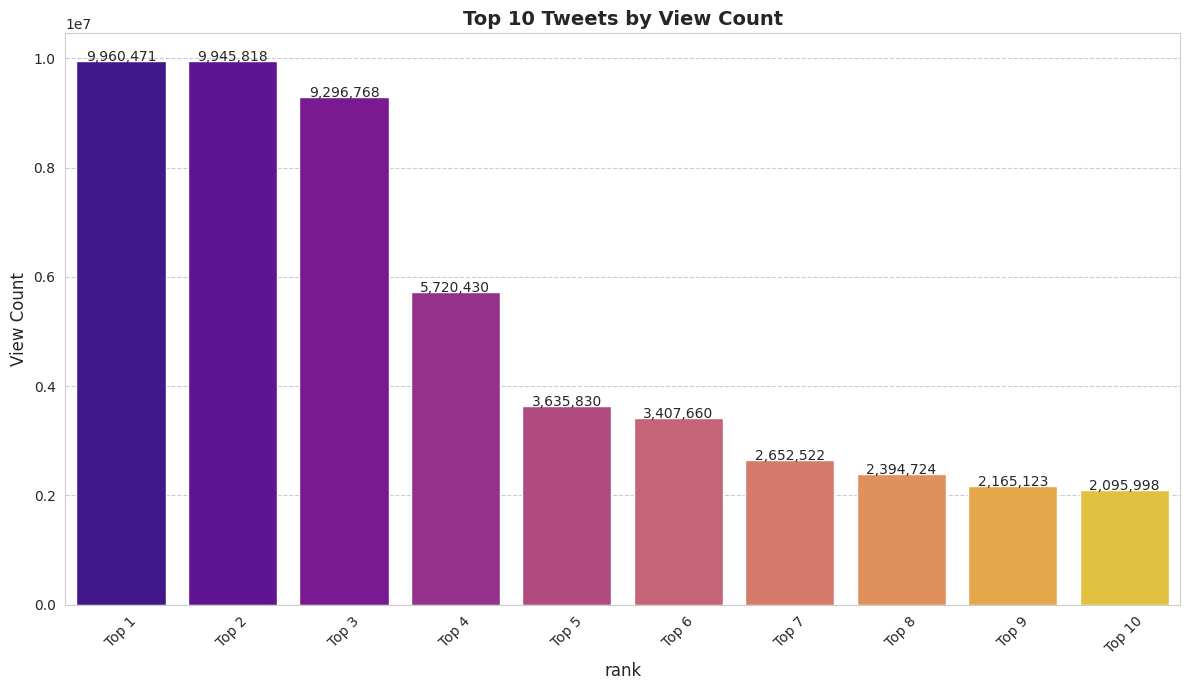


Top view count example:
- Sentiment: Negative
- Aspect: Climate Action and Policy
- Text: The Greenland ice cap is losing around 30 MILLION tonnes of ice an hour due to the climate crisis - 20% MORE than what scientists originally thought.

No time to waste. Stopfossifuels.

Creating composite engagement score...


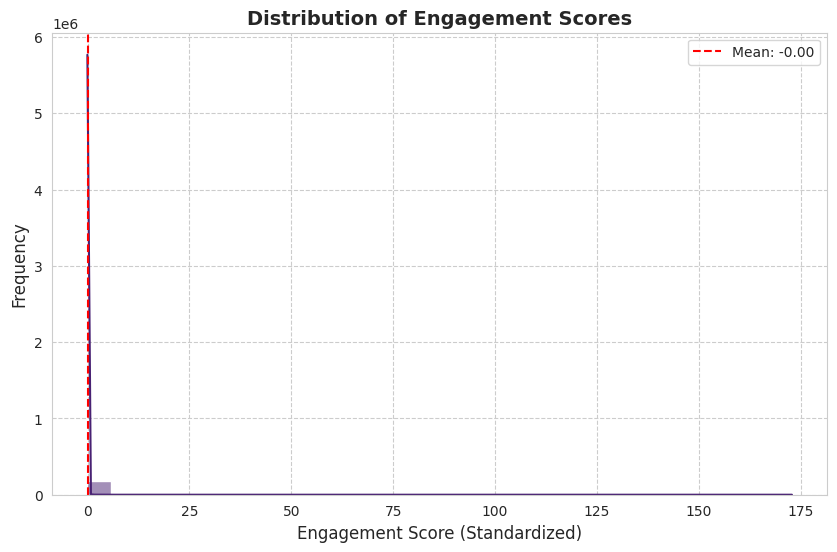

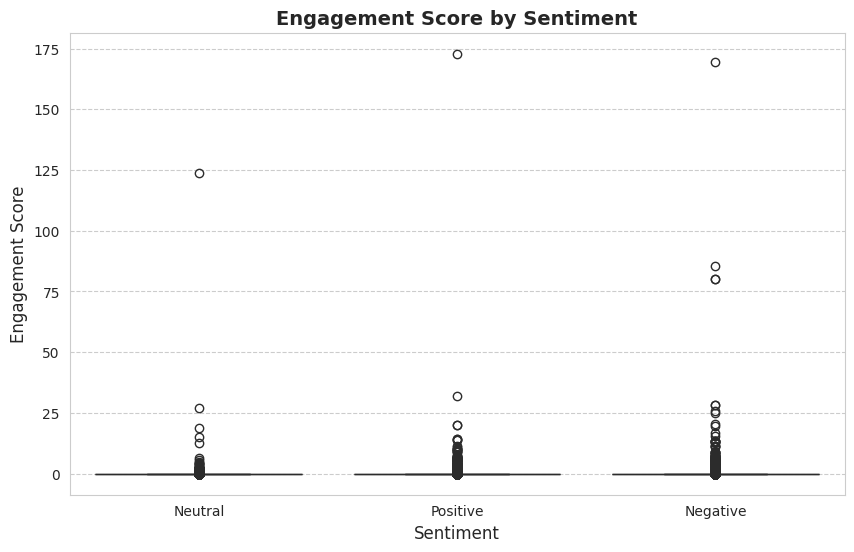

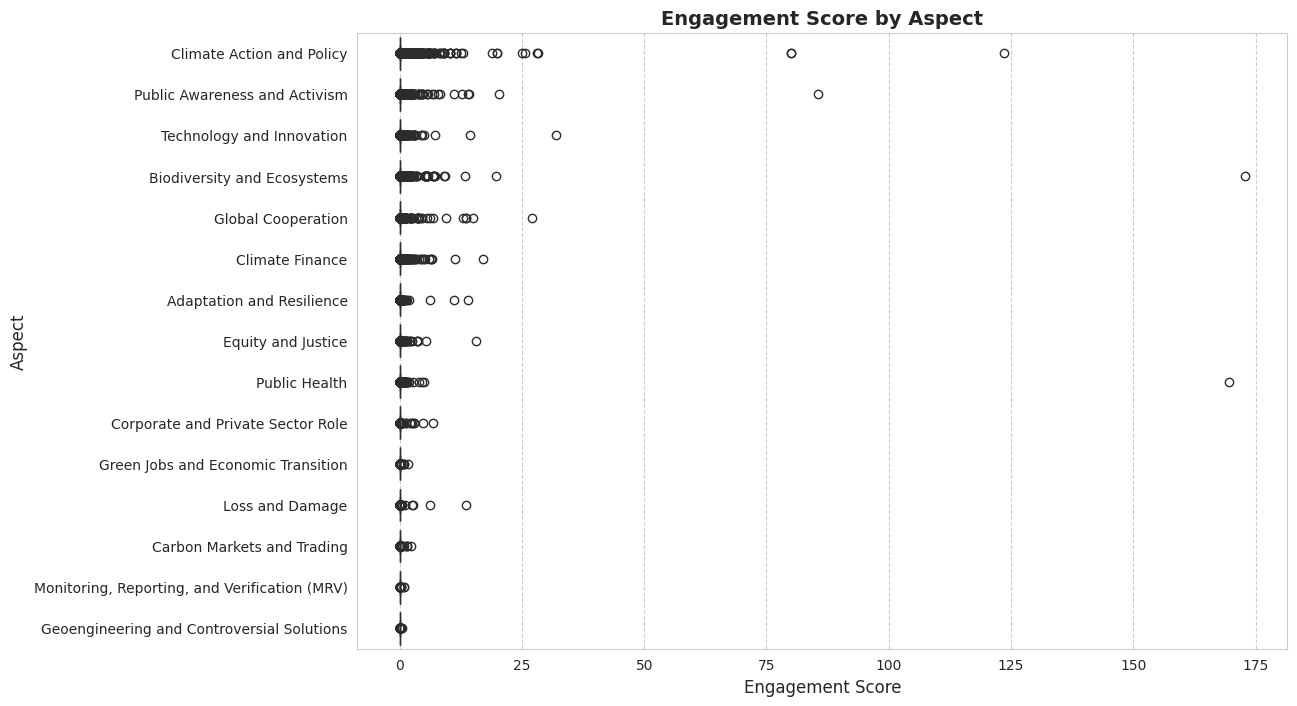


Top 10 most engaging tweets:
1. Sentiment: Positive, Aspect: Biodiversity and Ecosystems
   Text: Zoos are good. They do an enormous amount of conservation work and they’re very dedicated to protect...
   Engagement metrics: Retweets: 12969, Favorites: 216915, Replies: 816

2. Sentiment: Negative, Aspect: Public Health
   Text: Countless Americans are endangered now on a scale and intensity almost unheard of in modern America....
   Engagement metrics: Retweets: 13889, Favorites: 47349, Replies: 13545

3. Sentiment: Neutral, Aspect: Climate Action and Policy
   Text: nan...
   Engagement metrics: Retweets: 12042, Favorites: 207241, Replies: 170

4. Sentiment: Negative, Aspect: Public Awareness and Activism
   Text: The  nomination has been endangered entirely by anonymous sources. We have zero idea about the credi...
   Engagement metrics: Retweets: 12736, Favorites: 47868, Replies: 2812

5. Sentiment: Negative, Aspect: Climate Action and Policy
   Text: The Greenland ice cap is losin

In [ ]:

# --- Engagement Analysis --------------------------------------------------------
print("\n" + "=" * 50)
print("ENGAGEMENT ANALYSIS")
print("=" * 50)

# Analyze different engagement metrics
engagement_metrics = ['retweet_count', 'favorite_count', 'reply_count', 'view_count']
for metric in engagement_metrics:
    if metric in df.columns:
        analyze_engagement(df, metric)

# Create engagement score (composite metric)
print("\nCreating composite engagement score...")
engagement_columns = [col for col in engagement_metrics if col in df.columns]

if len(engagement_columns) > 0:
    # Standardize metrics
    scaler = StandardScaler()
    engagement_scaled = scaler.fit_transform(df[engagement_columns])
    engagement_df = pd.DataFrame(engagement_scaled, columns=engagement_columns)

    # Calculate engagement score (mean of standardized metrics)
    df['engagement_score'] = engagement_df.mean(axis=1)

    # Visualize engagement score distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['engagement_score'], kde=True, bins=30)
    plt.title('Distribution of Engagement Scores', fontweight='bold')
    plt.xlabel('Engagement Score (Standardized)')
    plt.ylabel('Frequency')
    plt.axvline(df['engagement_score'].mean(), color='red', linestyle='--',
                label=f'Mean: {df["engagement_score"].mean():.2f}')
    plt.legend()
    plt.show()

    # Engagement by sentiment
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='sentiment', y='engagement_score', data=df)
    plt.title('Engagement Score by Sentiment', fontweight='bold')
    plt.xlabel('Sentiment')
    plt.ylabel('Engagement Score')
    plt.show()

    # Engagement by aspect (top aspects)
    plt.figure(figsize=(12, 8))
    sns.boxplot(y='aspect', x='engagement_score', data=df[df['aspect'].isin(aspect_order)],
               order=aspect_order)
    plt.title('Engagement Score by Aspect', fontweight='bold')
    plt.ylabel('Aspect')
    plt.xlabel('Engagement Score')
    plt.show()

    # Find most engaging content (top 10 by engagement score)
    top_engaging = df.sort_values('engagement_score', ascending=False).head(10)
    print("\nTop 10 most engaging tweets:")
    for i, (_, row) in enumerate(top_engaging.iterrows(), 1):
        print(f"{i}. Sentiment: {row['sentiment']}, Aspect: {row['aspect']}")
        print(f"   Text: {row['cleaned_text'][:100]}...")
        print(f"   Engagement metrics: Retweets: {row['retweet_count']}, " +
             f"Favorites: {row['favorite_count']}, Replies: {row['reply_count']}")
        print()



CORRELATION ANALYSIS


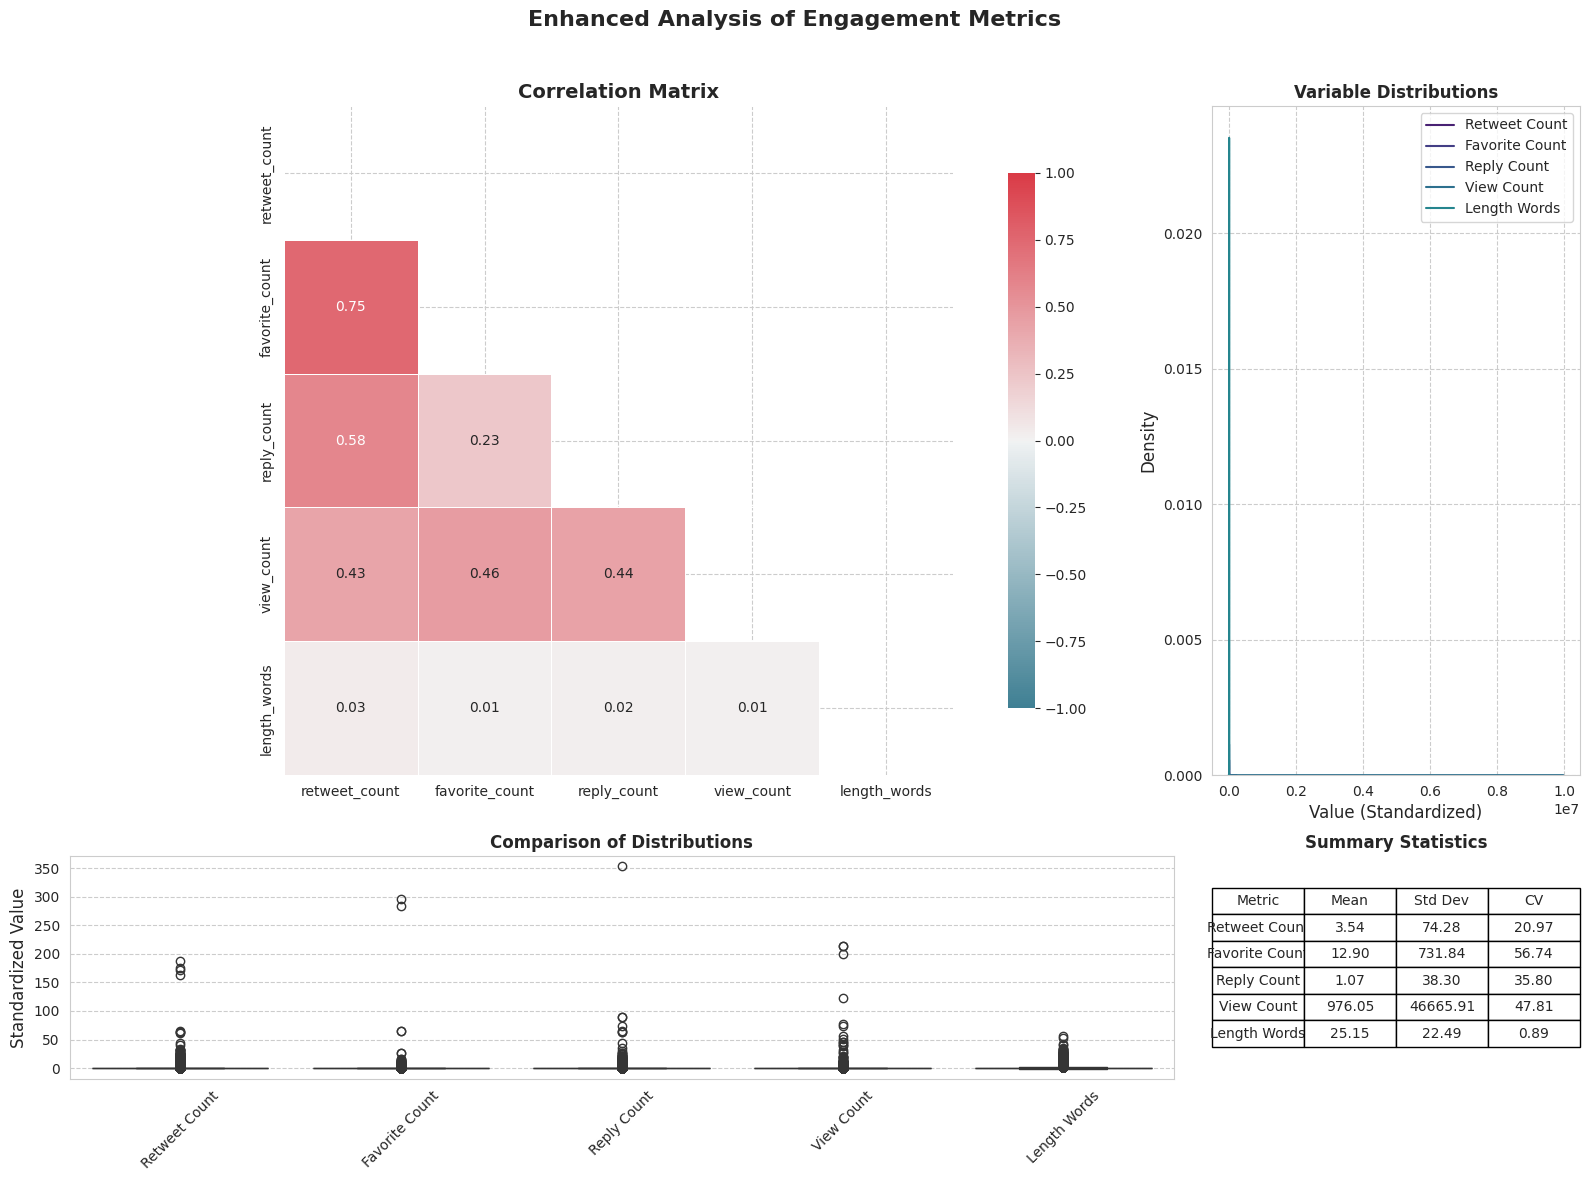


Statistical Insights:
- Retweet Count: 419 outliers detected (Z-score > 3)
- Favorite Count: 76 outliers detected (Z-score > 3)
- Reply Count: 203 outliers detected (Z-score > 3)
- View Count: 0 outliers detected (Z-score > 3)
- Length Words: 1334 outliers detected (Z-score > 3)

Strongest correlations:
- Retweet Count and Favorite Count: 0.749
- Favorite Count and Retweet Count: 0.749
- Retweet Count and Reply Count: 0.585

Analyzing correlation between sentiment and engagement...


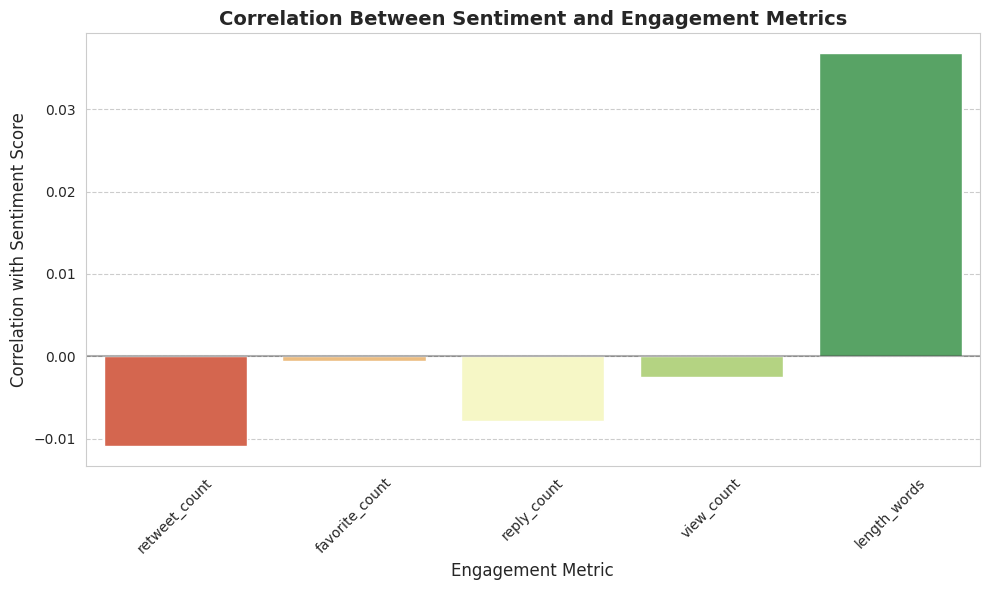


Sentiment Correlation Insights:
- Retweet Count has a weak negative correlation (-0.011) with sentiment
- Favorite Count has a weak negative correlation (-0.001) with sentiment
- Reply Count has a weak negative correlation (-0.008) with sentiment
- View Count has a weak negative correlation (-0.003) with sentiment
- Length Words has a weak positive correlation (0.037) with sentiment


In [ ]:

# --- Enhanced Correlation Analysis ----------------------------------------------
print("\n" + "=" * 50)
print("CORRELATION ANALYSIS")
print("=" * 50)

# Analyze correlation between engagement metrics
if len(engagement_columns) > 0:
    metrics_to_analyze = engagement_columns + ['length_words']

    # Create enhanced correlation plot
    corr_matrix = plot_enhanced_correlation(df, metrics_to_analyze,
                                          "Enhanced Analysis of Engagement Metrics")

    # Additional analysis: sentiment score correlation with engagement
    if 'sentiment_score' in df.columns:
        print("\nAnalyzing correlation between sentiment and engagement...")

        # Create composite metrics for analysis
        metrics_with_sentiment = metrics_to_analyze + ['sentiment_score']

        # Calculate correlations
        sentiment_corr = df[metrics_with_sentiment].corr()['sentiment_score'].drop('sentiment_score')

        # Visualize correlation between sentiment and engagement
        plt.figure(figsize=(10, 6))
        sns.barplot(x=sentiment_corr.index, y=sentiment_corr.values, palette='RdYlGn')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.title('Correlation Between Sentiment and Engagement Metrics', fontweight='bold')
        plt.xlabel('Engagement Metric')
        plt.ylabel('Correlation with Sentiment Score')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print insights
        print("\nSentiment Correlation Insights:")
        for metric, corr in sentiment_corr.items():
            direction = "positive" if corr > 0 else "negative"
            strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"

            print(f"- {metric.replace('_', ' ').title()} has a {strength} {direction} correlation ({corr:.3f}) with sentiment")

            if corr > 0.3:
                print(f"  This suggests more positive tweets tend to get more {metric.replace('_', ' ')}.")
            elif corr < -0.3:
                print(f"  This suggests more negative tweets tend to get more {metric.replace('_', ' ')}.")


TIME SERIES ANALYSIS
Analyzing time series from 2024-10-11 to 2024-12-10
Total days in time series: 61
Average tweets per day: 2989.3
Maximum tweets in a day: 14981 on 2024-11-21


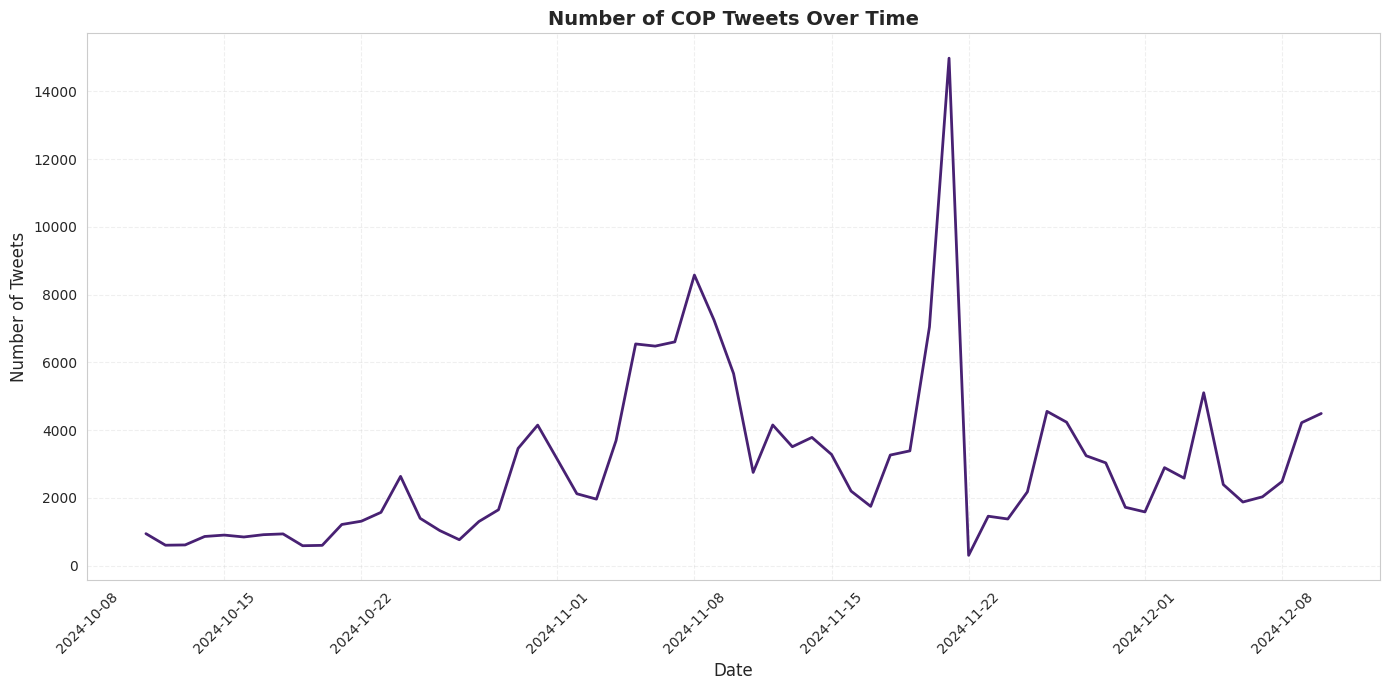

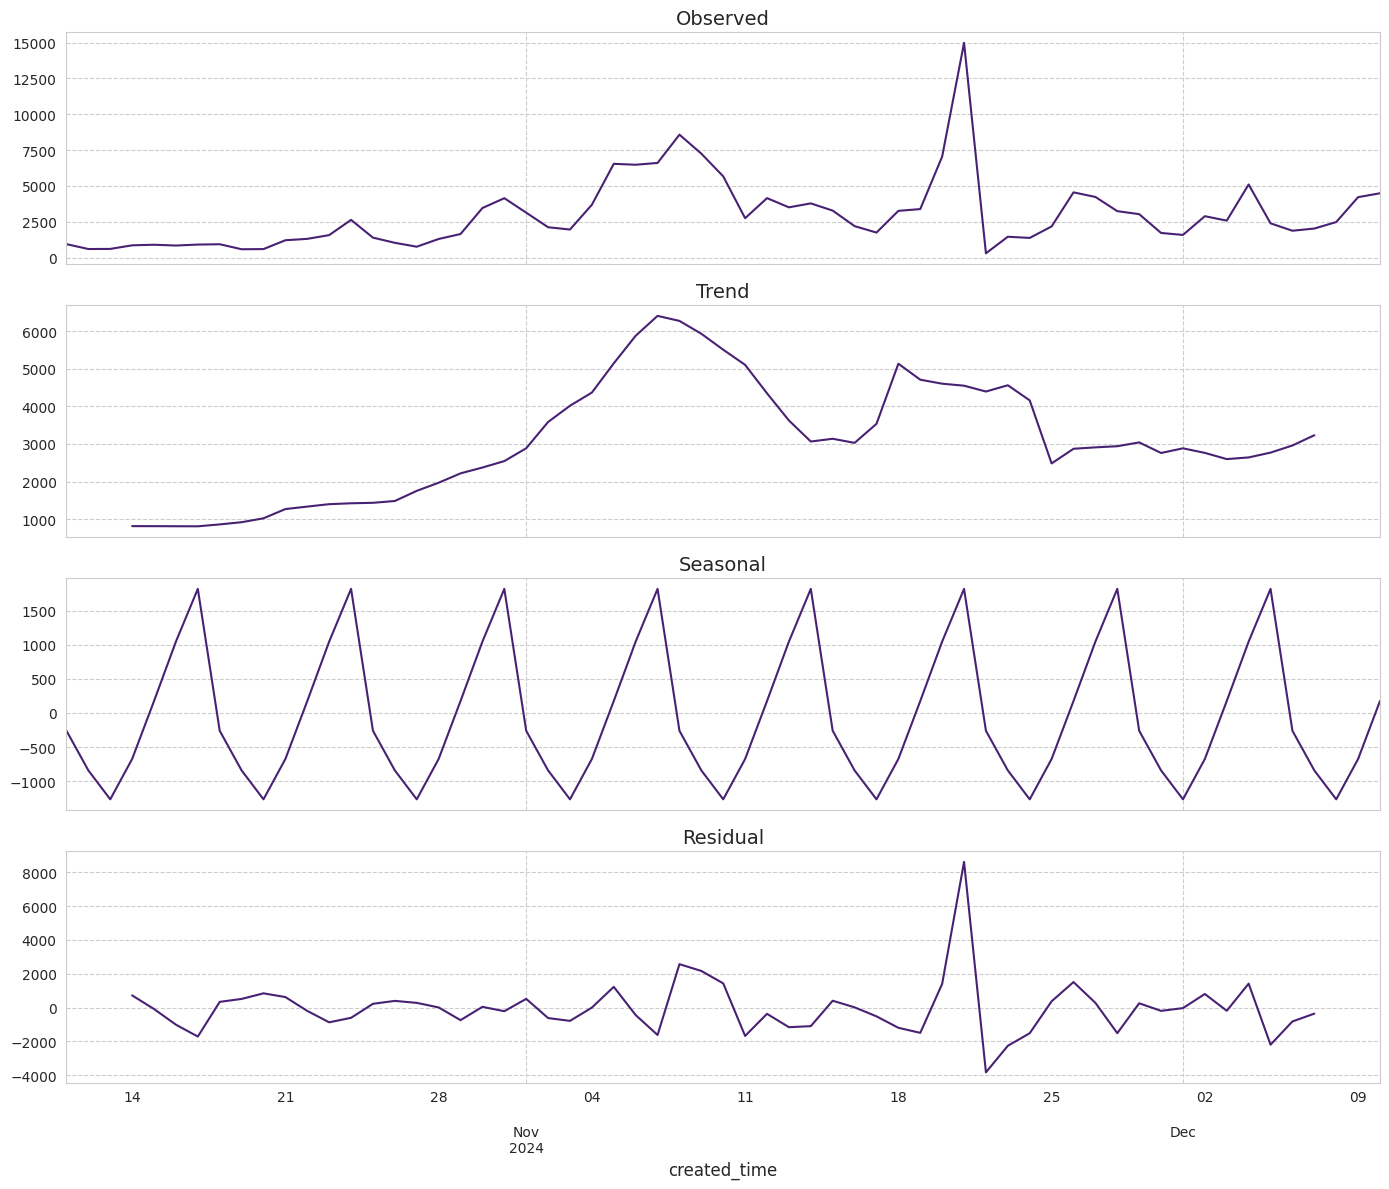


Analyzing sentiment trends over time...


<Figure size 1400x700 with 0 Axes>

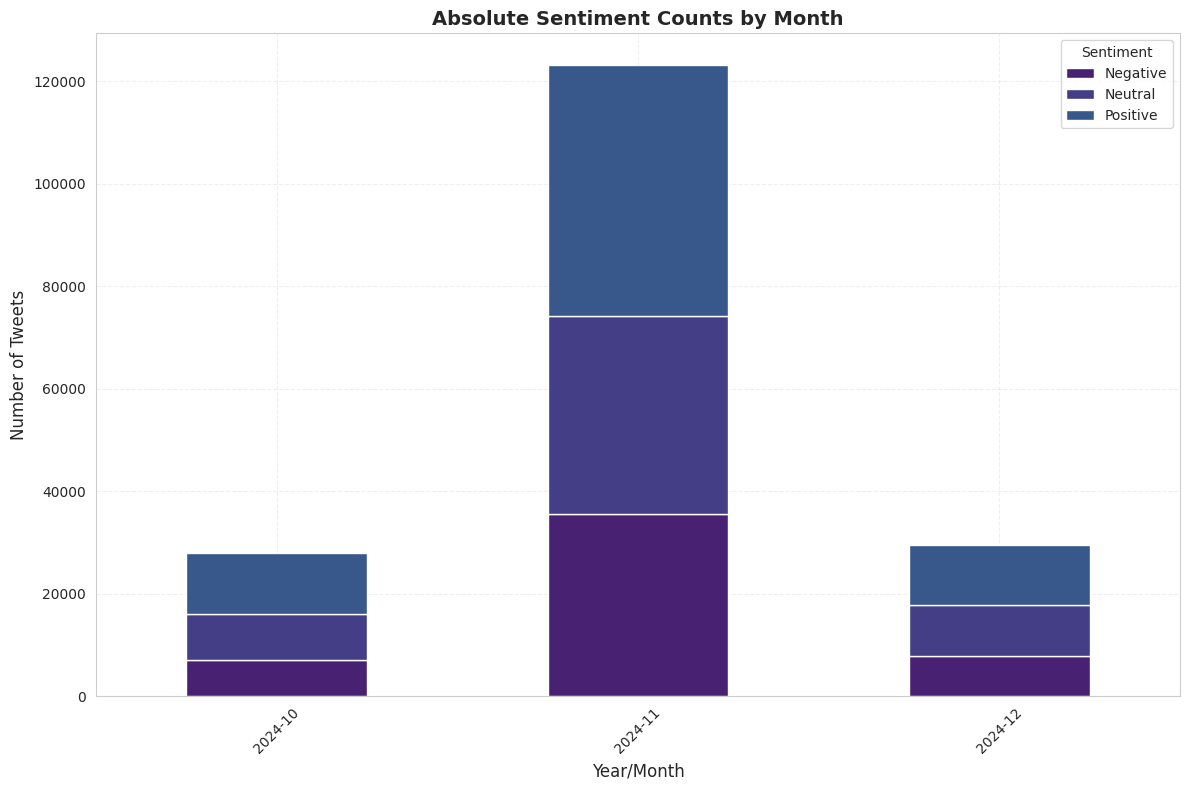

<Figure size 1400x700 with 0 Axes>

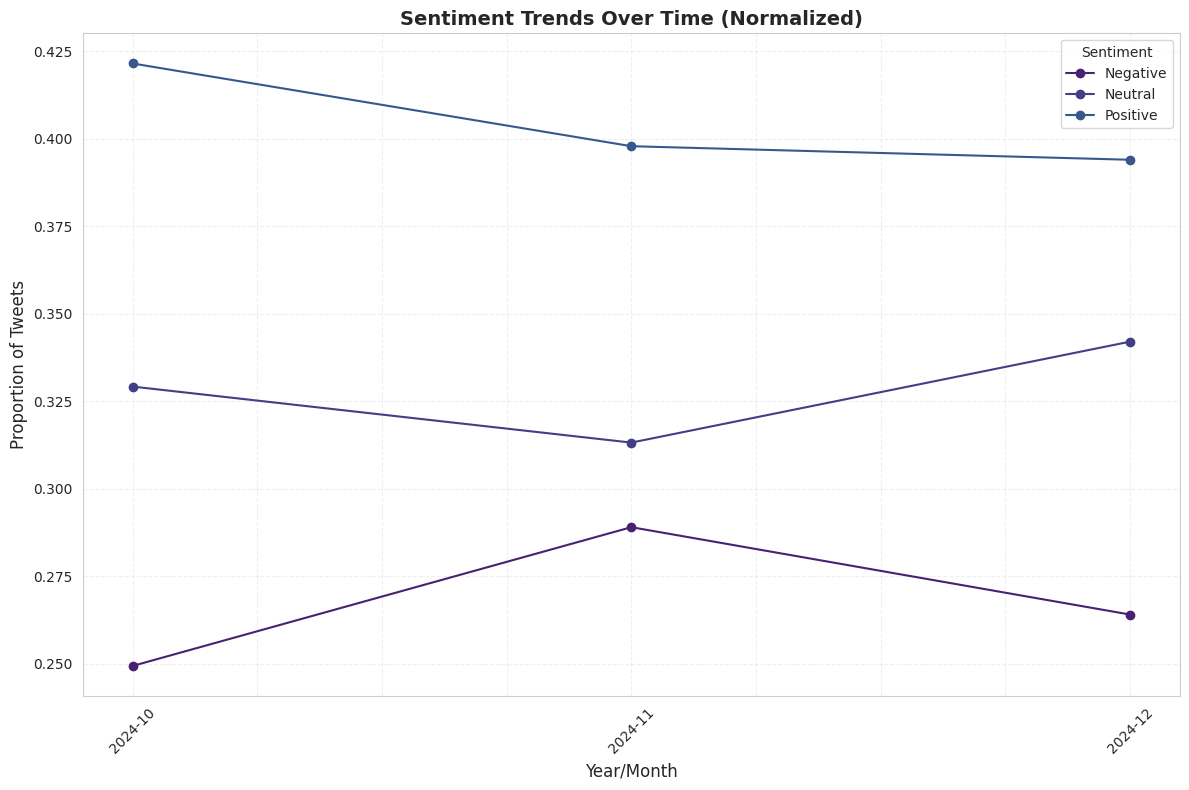

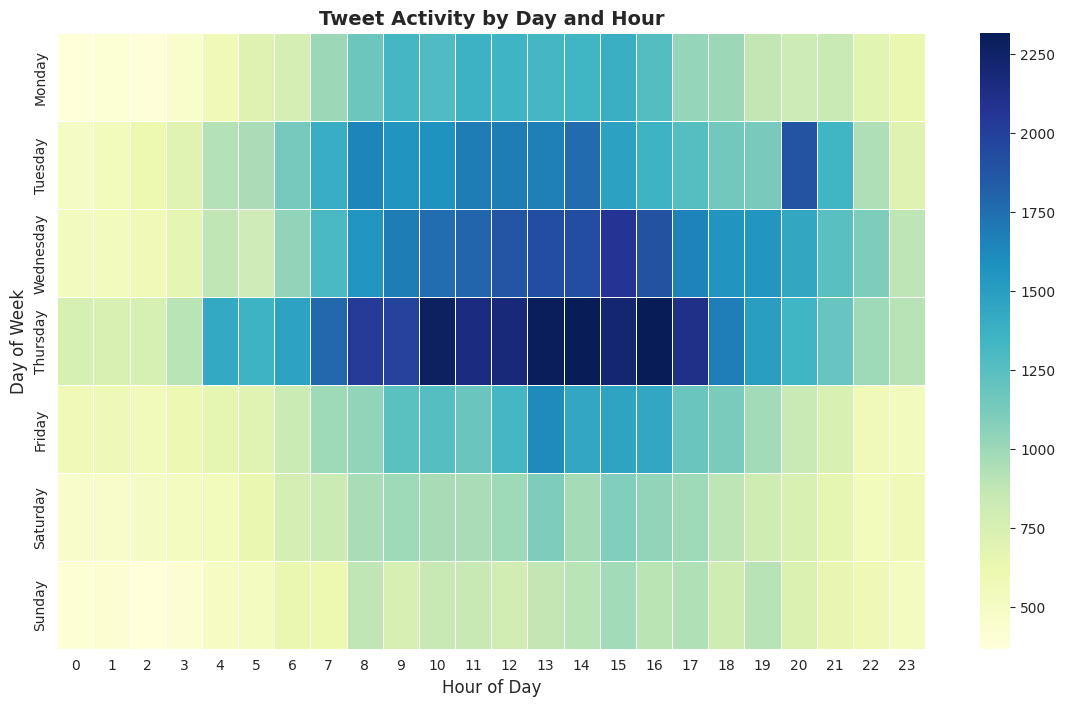

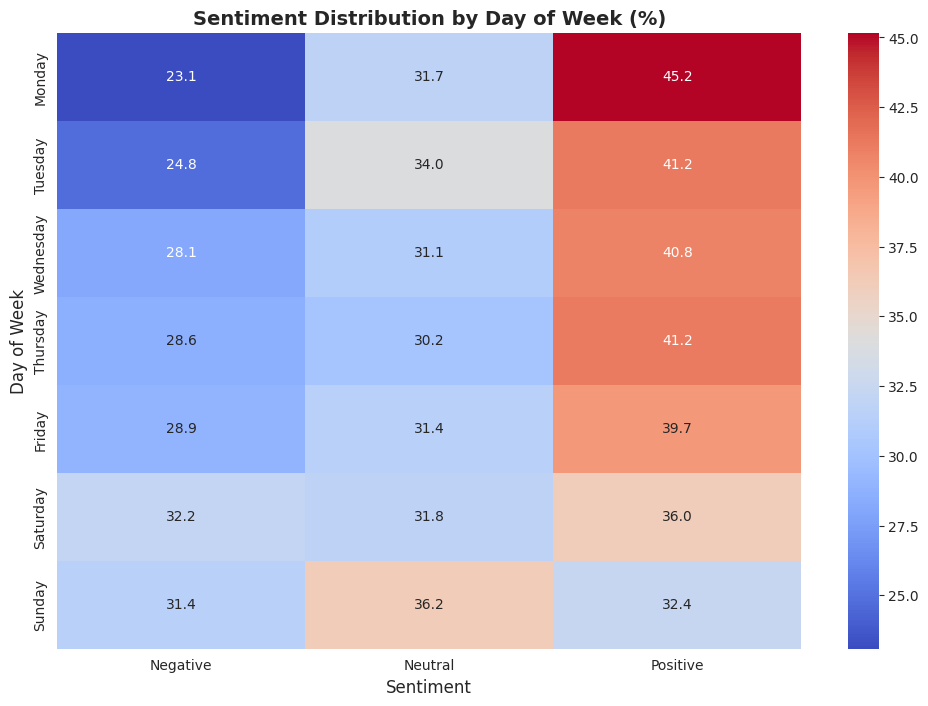

In [ ]:


# --- Time Series Analysis -------------------------------------------------------
print("\n" + "=" * 50)
print("TIME SERIES ANALYSIS")
print("=" * 50)

# Create time series of daily tweet counts
df_ts = df.set_index('created_time').copy()
df_daily = df_ts['cleaned_text'].resample('D').count()

print(f"Analyzing time series from {df_daily.index.min().date()} to {df_daily.index.max().date()}")
print(f"Total days in time series: {len(df_daily)}")
print(f"Average tweets per day: {df_daily.mean():.1f}")
print(f"Maximum tweets in a day: {df_daily.max()} on {df_daily.idxmax().date()}")

# Plot the time series
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily.values, linewidth=2)
plt.title('Number of COP Tweets Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Decompose the time series if we have enough data
if len(df_daily) >= 14:  # Need at least 2 weeks for meaningful decomposition
    try:
        # Use a reasonable period for seasonal decomposition
        decomposition_period = min(7, len(df_daily) // 2)  # Weekly seasonality or less
        result = seasonal_decompose(df_daily, model='additive', period=decomposition_period)

        # Plot the decomposition
        fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
        result.observed.plot(ax=axes[0], title='Observed')
        result.trend.plot(ax=axes[1], title='Trend')
        result.seasonal.plot(ax=axes[2], title='Seasonal')
        result.resid.plot(ax=axes[3], title='Residual')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not perform seasonal decomposition: {str(e)}")
else:
    print("Insufficient data for seasonal decomposition (need at least 14 days)")

# Sentiment trends over time
print("\nAnalyzing sentiment trends over time...")
sentiment_by_month = df.groupby(['year/month', 'sentiment']).size().unstack(fill_value=0)

# Calculate absolute counts
plt.figure(figsize=(14, 7))
sentiment_by_month.plot(kind='bar', stacked=True)
plt.title('Absolute Sentiment Counts by Month', fontsize=14, fontweight='bold')
plt.xlabel('Year/Month')
plt.ylabel('Number of Tweets')
plt.grid(True, alpha=0.3)
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Normalize to see proportion
sentiment_by_month_norm = sentiment_by_month.div(sentiment_by_month.sum(axis=1), axis=0)

# Plot normalized sentiment trends
plt.figure(figsize=(14, 7))
sentiment_by_month_norm.plot(kind='line', marker='o')
plt.title('Sentiment Trends Over Time (Normalized)', fontsize=14, fontweight='bold')
plt.xlabel('Year/Month')
plt.ylabel('Proportion of Tweets')
plt.grid(True, alpha=0.3)
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze tweet patterns by day of week and hour
day_hour_counts = df.groupby(['day_of_week', 'hour_of_day']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 8))
sns.heatmap(day_hour_counts, cmap='YlGnBu', linewidths=0.5, annot=False, fmt='.0f')
plt.title('Tweet Activity by Day and Hour', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

# Create heatmap of sentiment distribution by day of week
day_sentiment = pd.crosstab(df['day_of_week'], df['sentiment'], normalize='index') * 100

plt.figure(figsize=(12, 8))
sns.heatmap(day_sentiment, annot=True, fmt='.1f', cmap='coolwarm')
plt.title('Sentiment Distribution by Day of Week (%)', fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Day of Week')
plt.show()



TEXT CONTENT ANALYSIS

Generating word clouds...
There are 4,015,231 words in the combined texts.


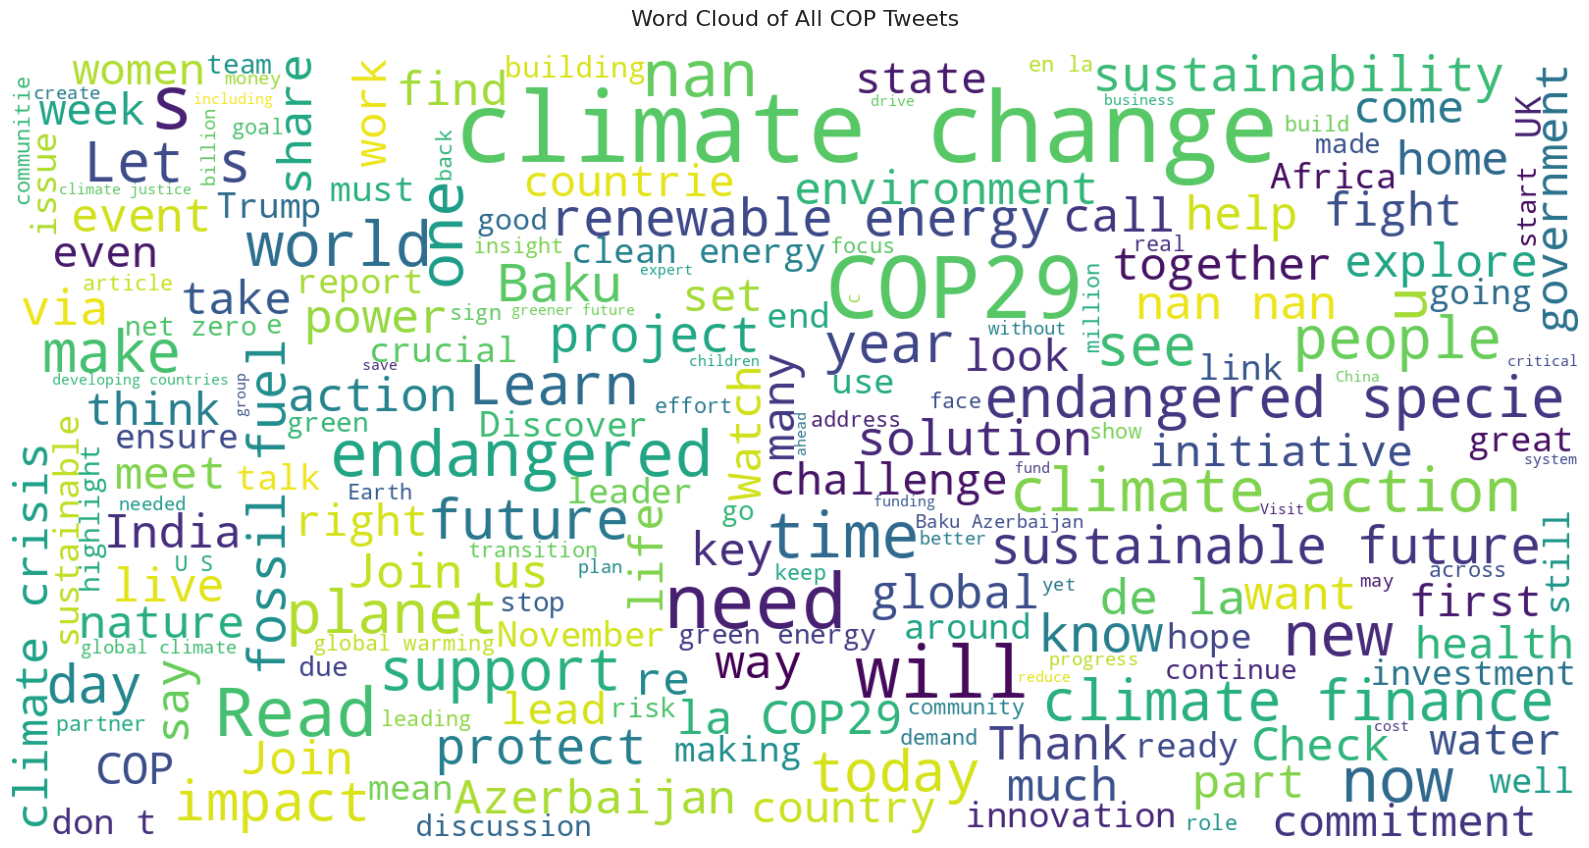

There are 807,923 words in the combined texts.


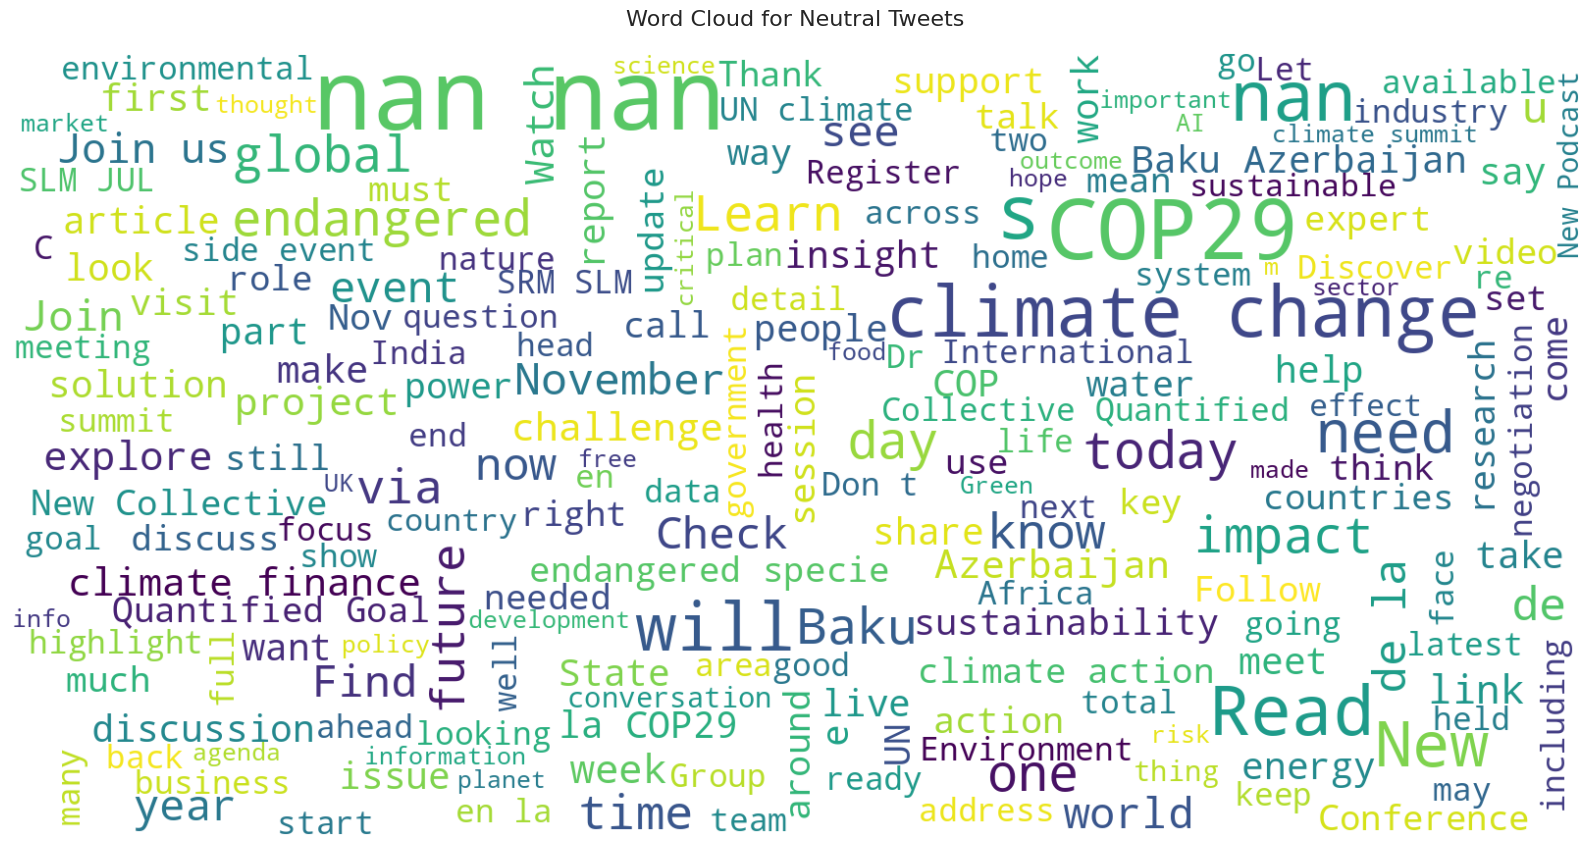

There are 1,883,794 words in the combined texts.


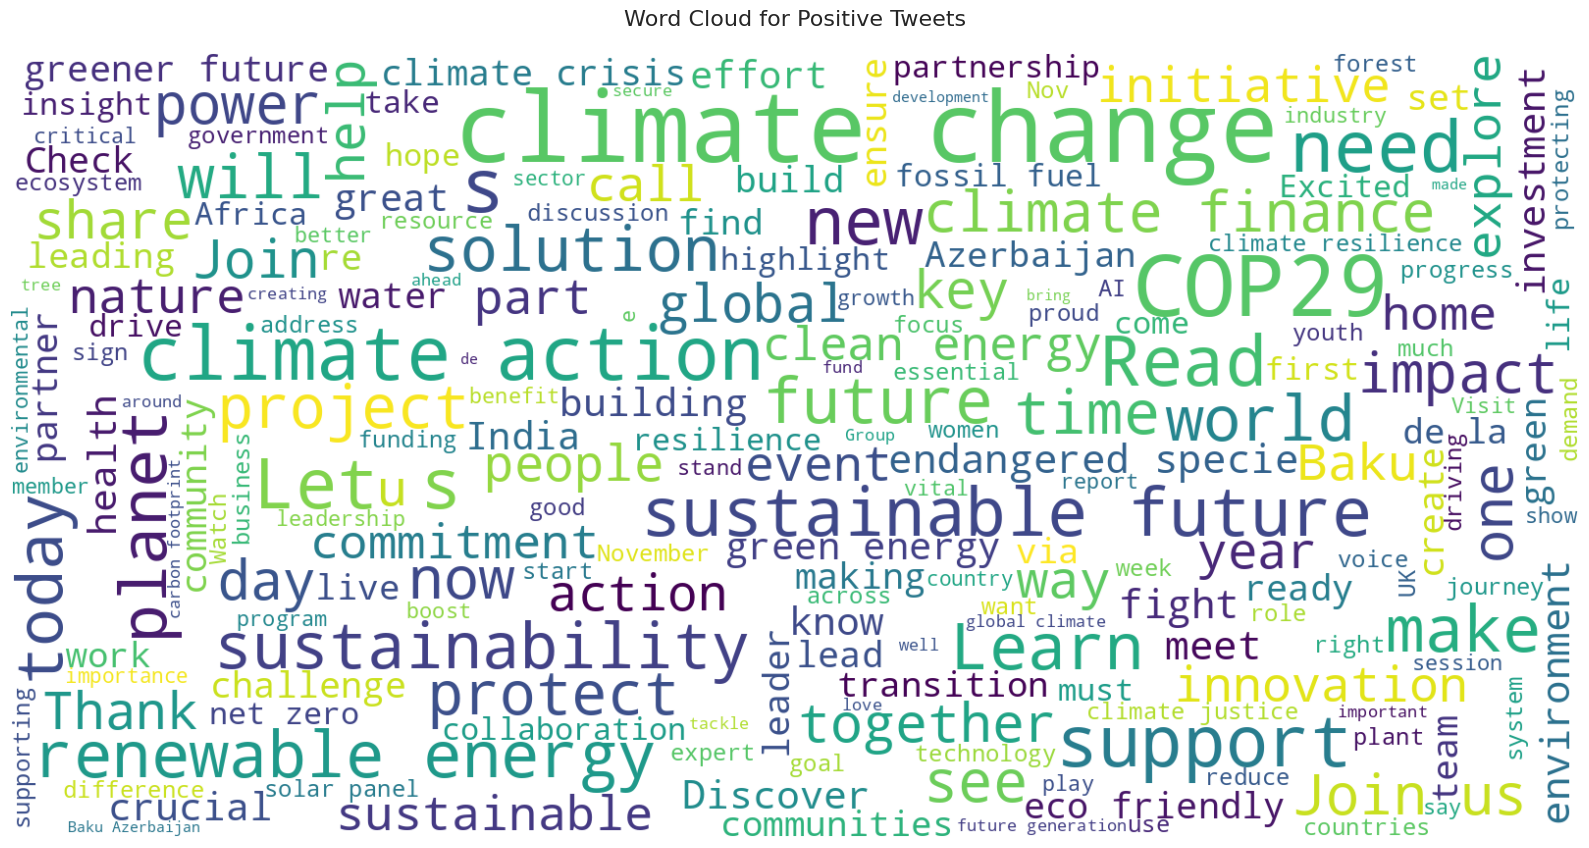

There are 1,293,928 words in the combined texts.


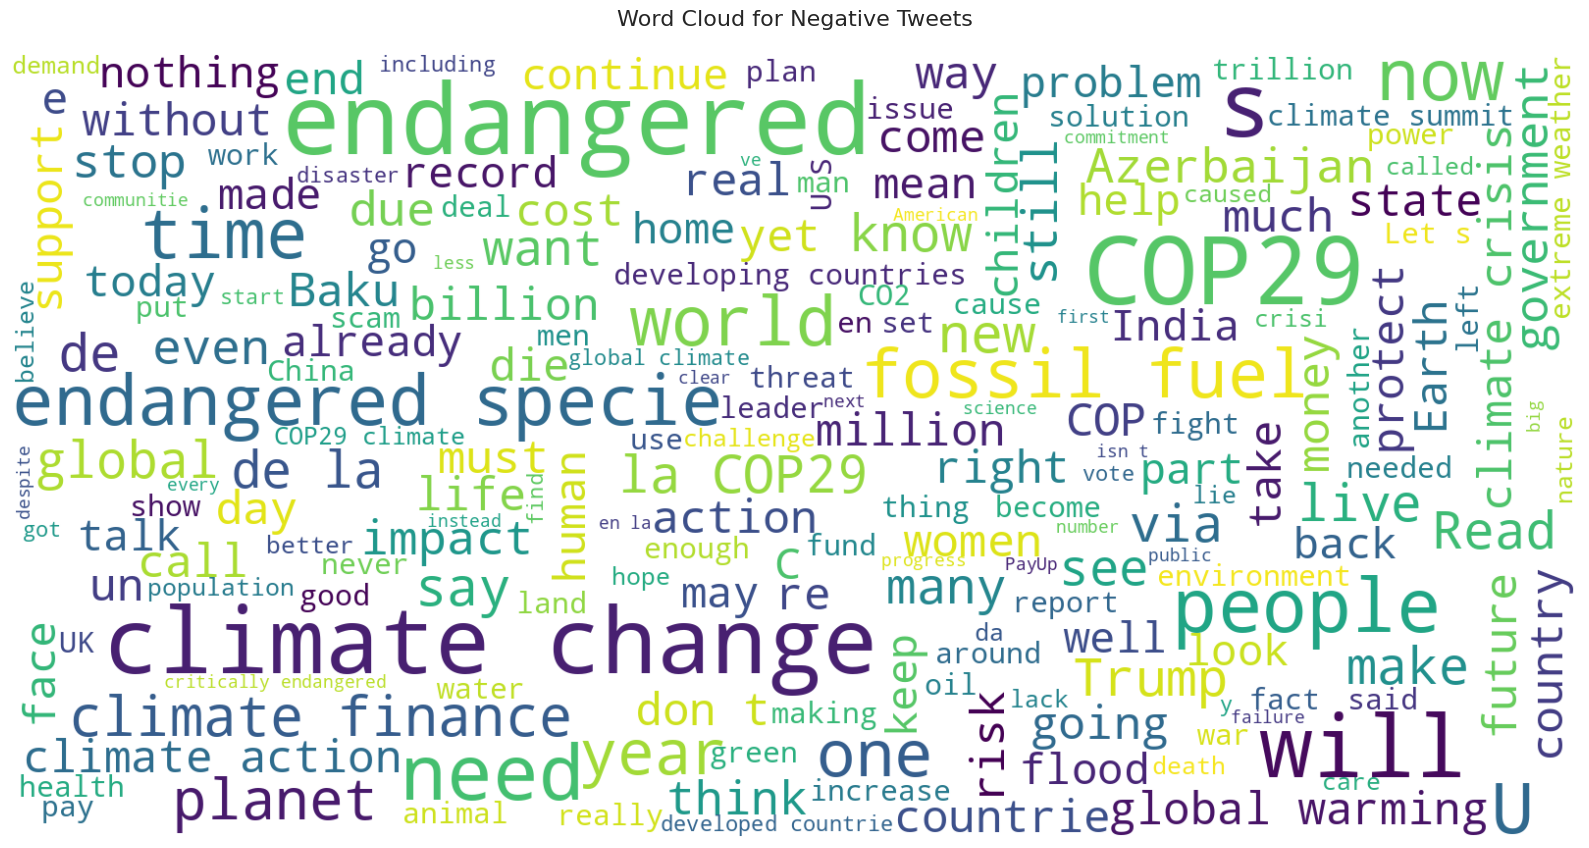

In [ ]:

# --- Word Cloud Visualization ---------------------------------------------------
print("\n" + "=" * 50)
print("TEXT CONTENT ANALYSIS")
print("=" * 50)

# Create a word cloud of all tweets
print("\nGenerating word clouds...")

# Generate overall word cloud
all_tweets_cloud = generate_wordcloud(df['cleaned_text'], title="Word Cloud of All COP Tweets")

# Generate word clouds by sentiment
for sentiment in df['sentiment'].unique():
    sentiment_text = df[df['sentiment'] == sentiment]['cleaned_text']
    if len(sentiment_text) > 0:  # Check if we have data for this sentiment
        generate_wordcloud(sentiment_text, f"Word Cloud for {sentiment} Tweets")



Generating N-gram analysis...


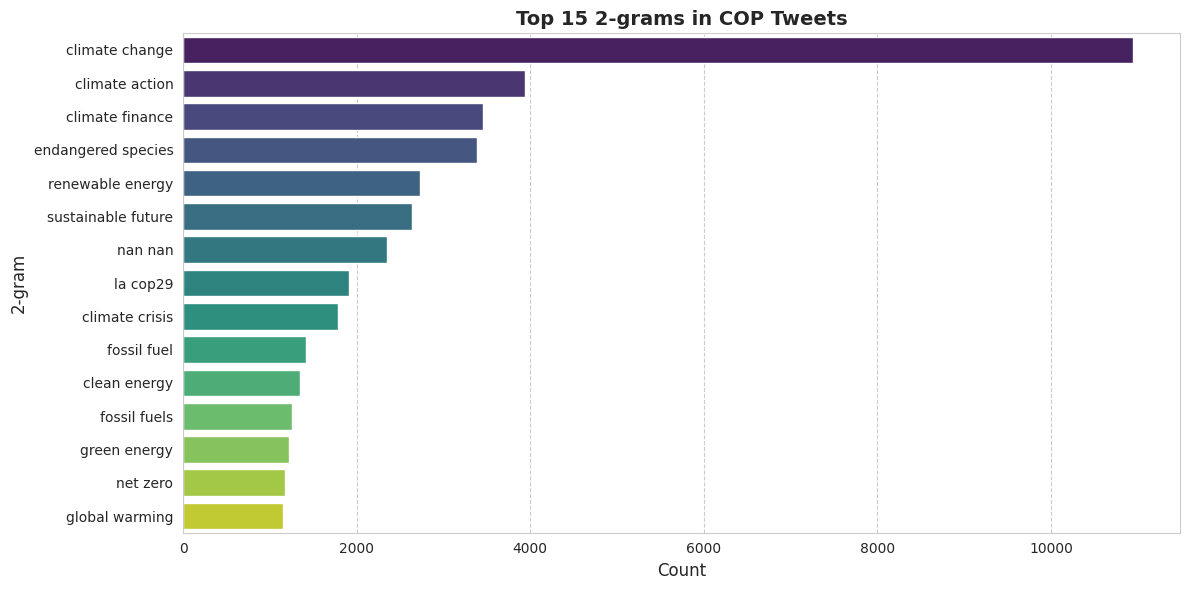

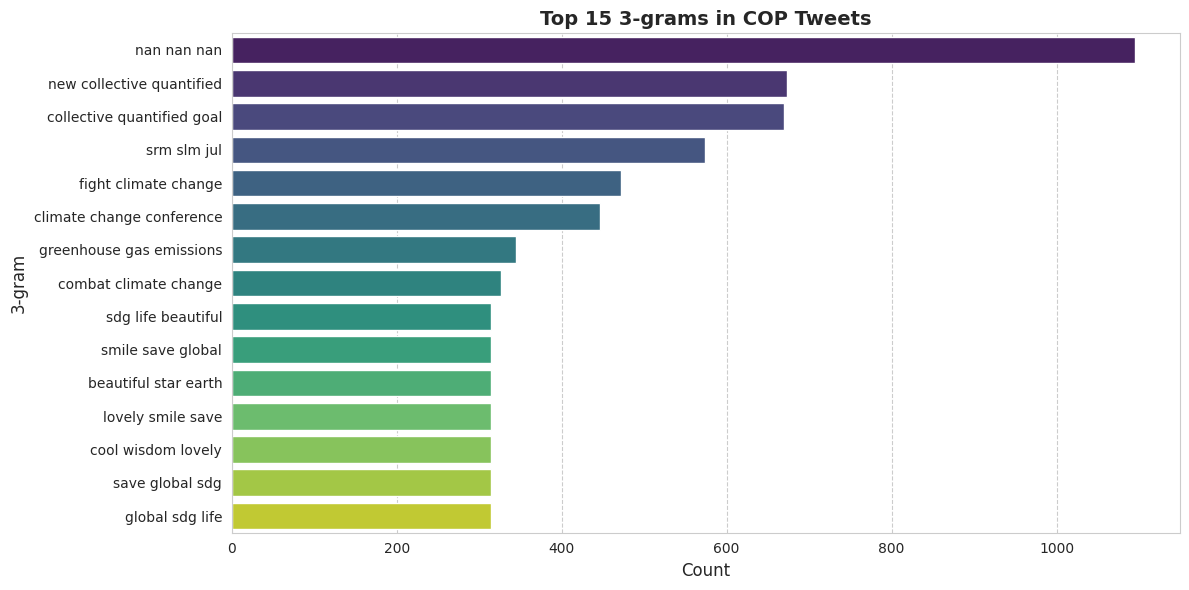

In [ ]:

# --- N-gram Analysis -----------------------------------------------------------
print("\nGenerating N-gram analysis...")

# Generate bigrams and trigrams
bigrams = generate_ngrams(df['cleaned_text'], n=2, top_n=15)
trigrams = generate_ngrams(df['cleaned_text'], n=3, top_n=15)


TOPIC CLUSTERING

Performing topic clustering using TF-IDF and K-means...
Determining optimal number of clusters...
For n_clusters = 2, the silhouette score is 0.039
For n_clusters = 3, the silhouette score is 0.091
For n_clusters = 4, the silhouette score is 0.090
For n_clusters = 5, the silhouette score is 0.093
For n_clusters = 6, the silhouette score is 0.091
For n_clusters = 7, the silhouette score is 0.095
For n_clusters = 8, the silhouette score is 0.093
For n_clusters = 9, the silhouette score is 0.096


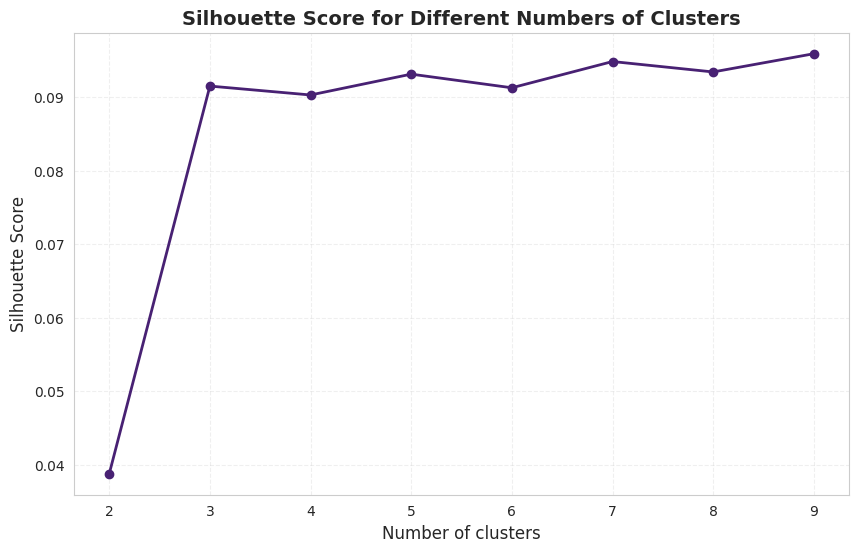

Optimal number of clusters: 9

Top terms for each topic cluster:
Cluster 0: thank, pls, join, colleagues, friends, members, following, ask, vs, press
Cluster 1: world, climate, leaders, change, future, cop29, let, global, sustainable, home
Cluster 2: nan, 2025, act, exciting, expected, experience, expert, experts, explore, family
Cluster 3: climate, change, action, cop29, finance, global, crisis, future, countries, baku
Cluster 4: cop29, da, və, في, baku, ve, azerbaijan, na, 29, ev
Cluster 5: la, en, el, cop29, que, le, les, los, para, des
Cluster 6: energy, future, new, solar, sustainable, green, let, read, global, just
Cluster 7: endangered, species, people, like, critically, list, animals, wildlife, lives, protect
Cluster 8: di, il, la, che, cop29, non, del, le, una, al


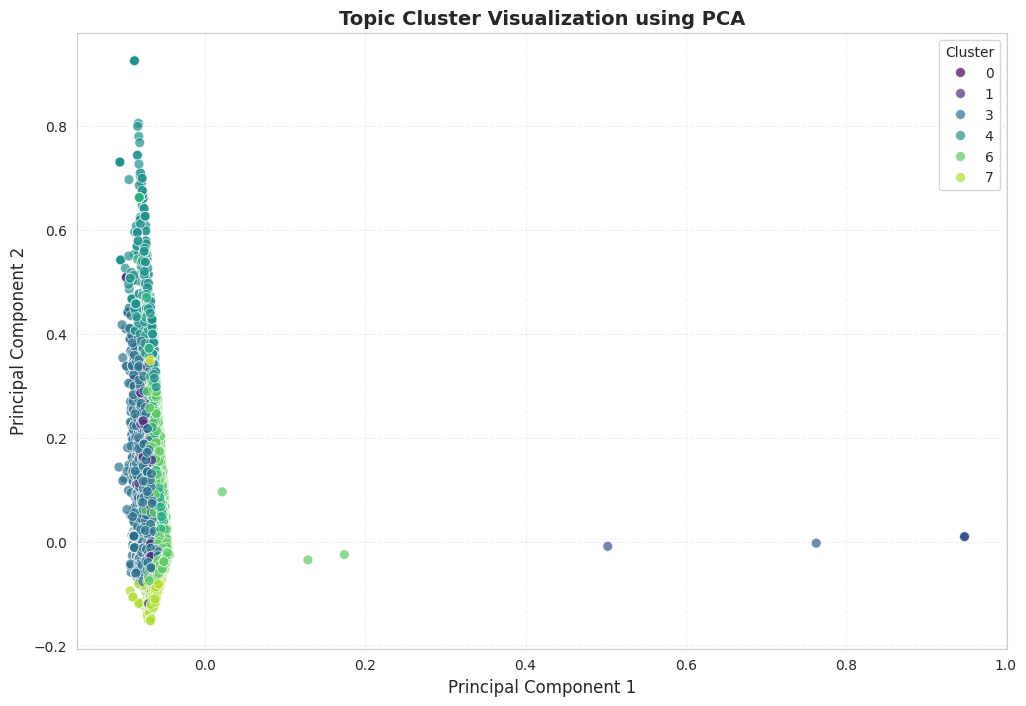

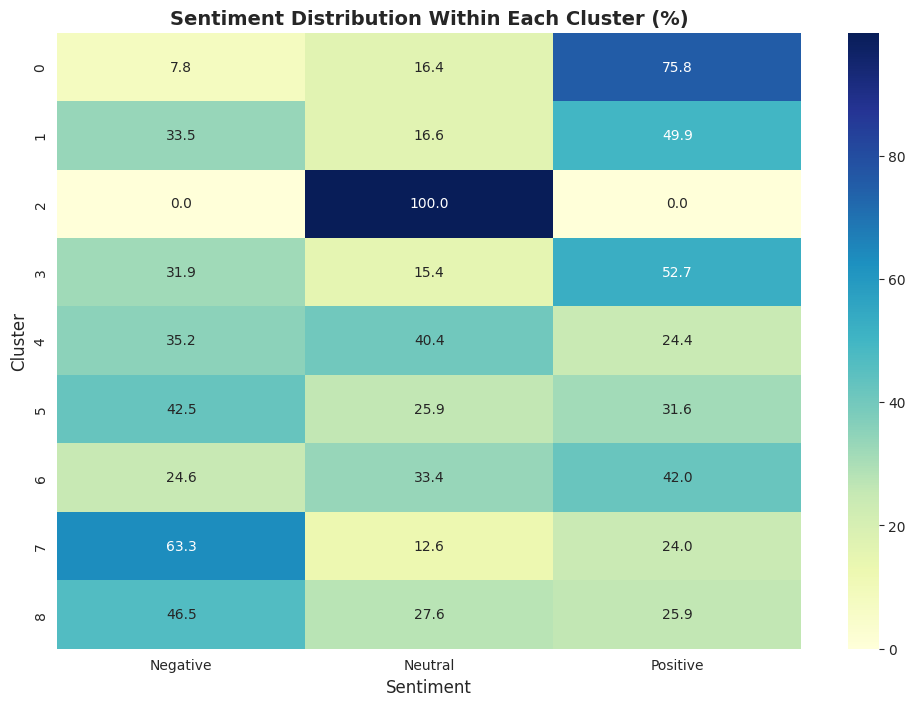


Cluster-Sentiment Relationship Insights:
Cluster 0 (1327 tweets, 0.7% of total):
  Top terms: thank, pls, join, colleagues, friends
  Dominant sentiment: Positive (75.8%)
  Example tweet: I'm deeply concerned about the American Red Wolf's critically endangered status. Thank you for shedd...

Cluster 1 (6944 tweets, 3.8% of total):
  Top terms: world, climate, leaders, change, future
  Dominant sentiment: Positive (49.9%)
  Example tweet: Save the Pacific, Save the World - PIF SG Waqa at  

The 1.5-degree goal in the  represents a critic...

Cluster 2 (10347 tweets, 5.7% of total):
  Top terms: nan, 2025, act, exciting, expected
  Dominant sentiment: Neutral (100.0%)
  Example tweet: nan...

Cluster 3 (28356 tweets, 15.6% of total):
  Top terms: climate, change, action, cop29, finance
  Dominant sentiment: Positive (52.7%)
  Example tweet: 5/8 

Unfortunately, many animal species are facing unprecedented threats due to habitat destruction...

Cluster 4 (3924 tweets, 2.2% of total):
  T

In [ ]:


# --- Topic Clustering ----------------------------------------------------------
print("\n" + "=" * 50)
print("TOPIC CLUSTERING")
print("=" * 50)
print("\nPerforming topic clustering using TF-IDF and K-means...")

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    min_df=5  # Minimum document frequency
)

# Check if we have enough data for meaningful clustering
if len(df) > 100:  # Only do clustering if we have at least 100 tweets
    # Fit and transform the text data
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

    # Determine optimal number of clusters using silhouette score
    silhouette_scores = []
    k_range = range(2, min(10, len(df) // 20))  # Try different numbers of clusters

    print("Determining optimal number of clusters...")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(tfidf_matrix)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"For n_clusters = {k}, the silhouette score is {silhouette_avg:.3f}")

    # Plot silhouette scores
    plt.figure(figsize=(10, 6))
    plt.plot(list(k_range), silhouette_scores, 'o-', linewidth=2)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Different Numbers of Clusters', fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Choose the optimal number of clusters (highest silhouette score)
    optimal_k = list(k_range)[silhouette_scores.index(max(silhouette_scores))]
    print(f"Optimal number of clusters: {optimal_k}")

    # Apply K-means with optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(tfidf_matrix)

    # Get top terms for each cluster
    top_terms = get_top_terms_per_cluster(kmeans, tfidf_vectorizer, n_terms=10)

    # Display top terms for each cluster
    print("\nTop terms for each topic cluster:")
    for cluster, terms in top_terms.items():
        print(f"Cluster {cluster}: {', '.join(terms)}")

    # Visualize clusters with PCA
    # Reduce dimensions for visualization
    pca = PCA(n_components=2, random_state=42)
    tfidf_pca = pca.fit_transform(tfidf_matrix.toarray())

    # Create a DataFrame for plotting
    cluster_df = pd.DataFrame({
        'x': tfidf_pca[:, 0],
        'y': tfidf_pca[:, 1],
        'cluster': df['cluster'],
        'sentiment': df['sentiment']
    })

    # Plot clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='x', y='y', hue='cluster', data=cluster_df, palette='viridis', s=50, alpha=0.7)
    plt.title('Topic Cluster Visualization using PCA', fontweight='bold')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Relationship between clusters and sentiment
    cluster_sentiment = pd.crosstab(df['cluster'], df['sentiment'], normalize='index') * 100

    # Visualize relationship
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_sentiment, annot=True, fmt='.1f', cmap='YlGnBu')
    plt.title('Sentiment Distribution Within Each Cluster (%)', fontweight='bold')
    plt.xlabel('Sentiment')
    plt.ylabel('Cluster')
    plt.show()

    # Print insights about clusters
    print("\nCluster-Sentiment Relationship Insights:")
    for cluster in range(optimal_k):
        dominant_sentiment = cluster_sentiment.loc[cluster].idxmax()
        dominant_percentage = cluster_sentiment.loc[cluster].max()

        cluster_size = (df['cluster'] == cluster).sum()
        cluster_percentage = cluster_size / len(df) * 100

        print(f"Cluster {cluster} ({cluster_size} tweets, {cluster_percentage:.1f}% of total):")
        print(f"  Top terms: {', '.join(top_terms[cluster][:5])}")
        print(f"  Dominant sentiment: {dominant_sentiment} ({dominant_percentage:.1f}%)")

        # Find examples from this cluster
        example = df[df['cluster'] == cluster].iloc[0]
        print(f"  Example tweet: {example['cleaned_text'][:100]}...")
        print()
else:
    print("Insufficient data for meaningful topic clustering (need at least 100 tweets)")


USER ANALYSIS

Top 20 Most Active Users:
1. author_17763: 1428 tweets (0.8%)
2. author_41557: 1369 tweets (0.8%)
3. author_22668: 772 tweets (0.4%)
4. author_61673: 689 tweets (0.4%)
5. author_25902: 655 tweets (0.4%)
6. author_48832: 536 tweets (0.3%)
7. author_24999: 514 tweets (0.3%)
8. author_50879: 500 tweets (0.3%)
9. author_61091: 492 tweets (0.3%)
10. author_45577: 452 tweets (0.2%)
11. author_2869: 391 tweets (0.2%)
12. author_39728: 374 tweets (0.2%)
13. author_44899: 370 tweets (0.2%)
14. author_15084: 314 tweets (0.2%)
15. author_15088: 303 tweets (0.2%)
16. author_40544: 278 tweets (0.2%)
17. author_50074: 272 tweets (0.1%)
18. author_58723: 237 tweets (0.1%)
19. author_31089: 233 tweets (0.1%)
20. author_12557: 225 tweets (0.1%)


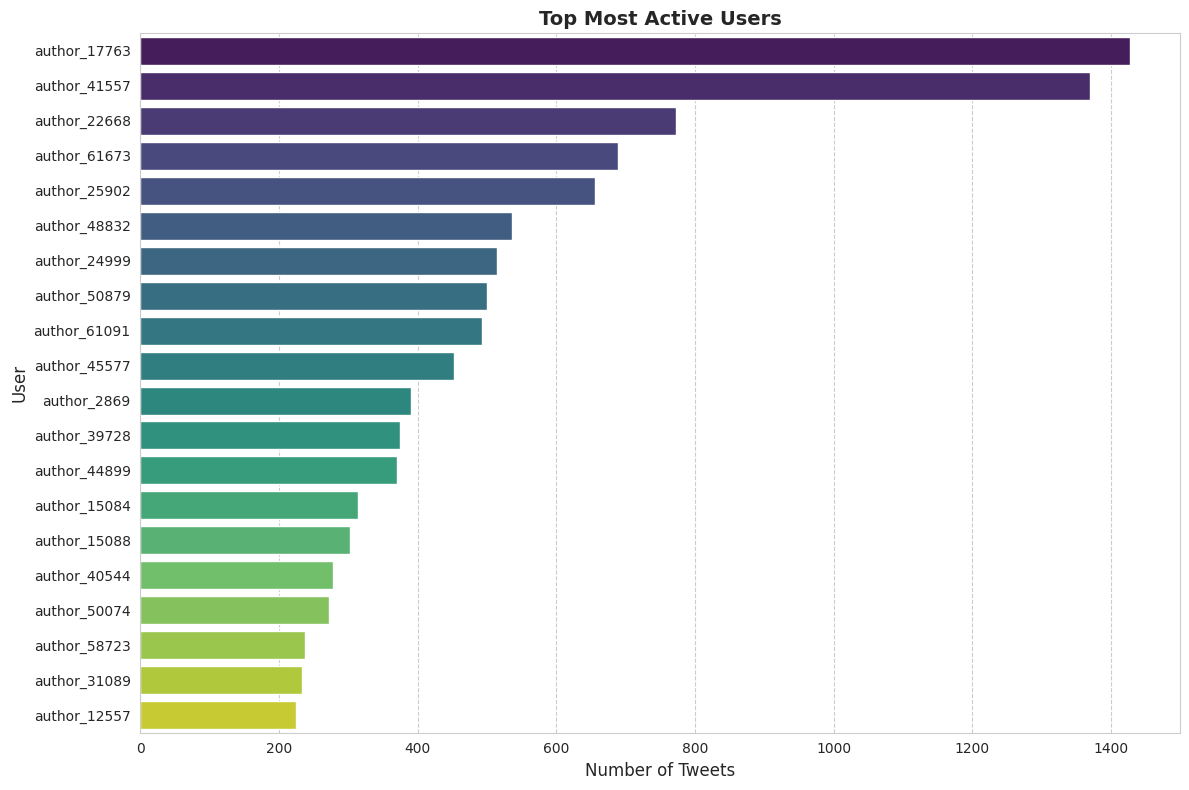

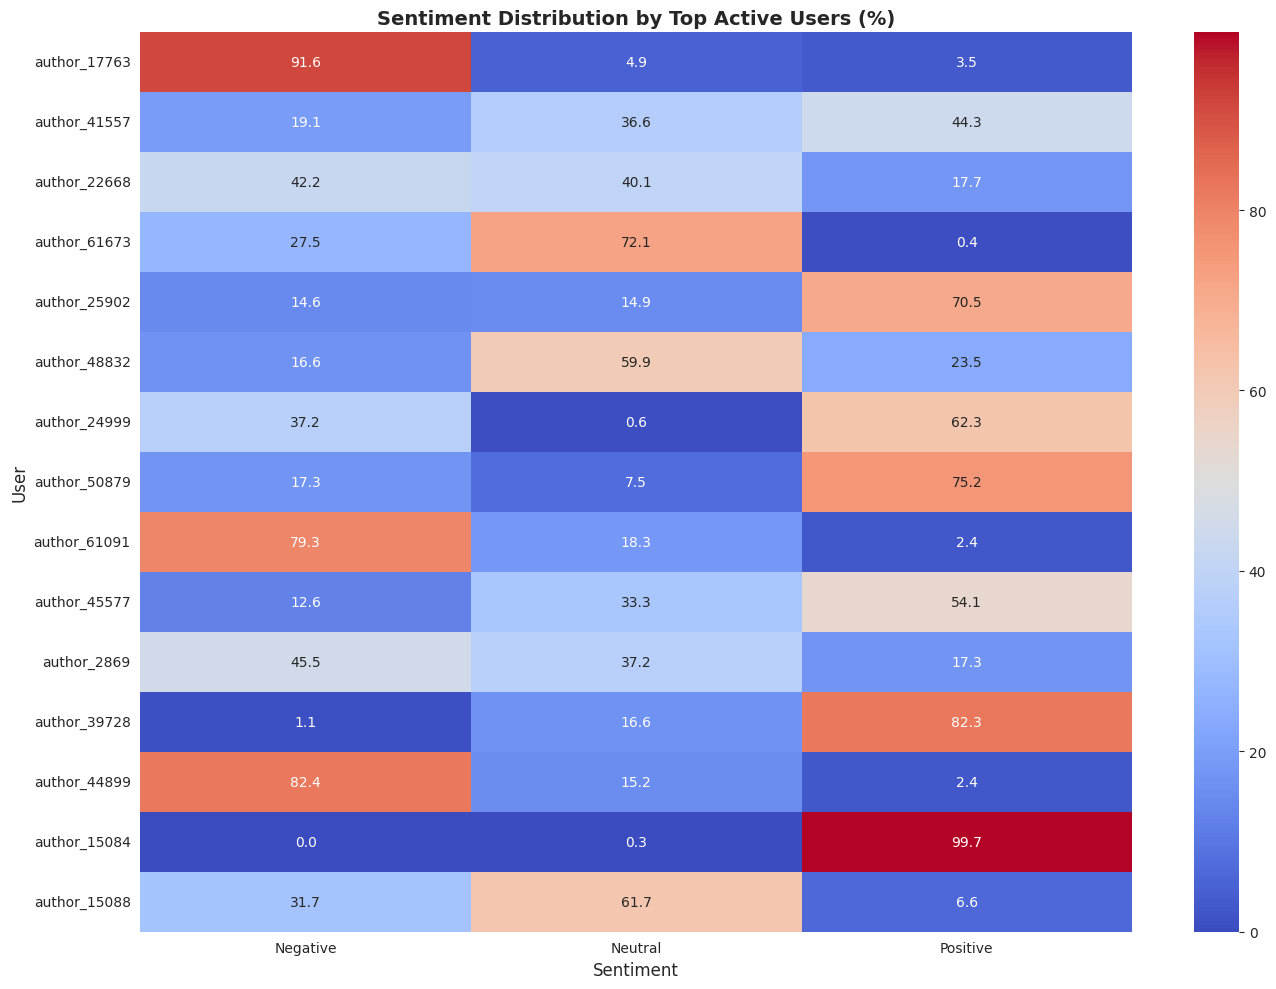


Users with Strongest Positive Bias:
- author_1024: 100.0% positive, 0.0% negative
- author_10221: 100.0% positive, 0.0% negative
- author_996: 100.0% positive, 0.0% negative
- author_45556: 100.0% positive, 0.0% negative
- author_45005: 100.0% positive, 0.0% negative

Users with Strongest Negative Bias:
- author_38867: 0.0% positive, 100.0% negative
- author_57961: 0.0% positive, 100.0% negative
- author_57926: 0.0% positive, 100.0% negative
- author_37208: 0.0% positive, 100.0% negative
- author_41625: 0.0% positive, 100.0% negative


In [ ]:


# --- User Analysis -------------------------------------------------------------
print("\n" + "=" * 50)
print("USER ANALYSIS")
print("=" * 50)

# Analyze user activity
if 'author_username' in df.columns:
    user_activity = df['author_username'].value_counts()
    top_users = min(20, len(user_activity))

    print(f"\nTop {top_users} Most Active Users:")
    for i, (user, count) in enumerate(user_activity.head(top_users).items(), 1):
        print(f"{i}. {user}: {count} tweets ({count/len(df)*100:.1f}%)")

    plt.figure(figsize=(12, 8))
    sns.barplot(y=user_activity.head(top_users).index,
                x=user_activity.head(top_users).values,
                palette='viridis')
    plt.title('Top Most Active Users', fontweight='bold')
    plt.xlabel('Number of Tweets')
    plt.ylabel('User')
    plt.tight_layout()
    plt.show()

    # User sentiment analysis for active users
    min_tweets = 5  # Only consider users with at least 5 tweets
    user_counts = df['author_username'].value_counts()
    active_users = user_counts[user_counts >= min_tweets].index

    if len(active_users) > 0:
        user_sentiment = pd.crosstab(
            df[df['author_username'].isin(active_users)]['author_username'],
            df[df['author_username'].isin(active_users)]['sentiment'],
            normalize='index'
        ).mul(100).round(1)

        # Show top users by activity
        top_n_active = min(15, len(user_sentiment))
        user_sentiment_top = user_sentiment.loc[user_activity.head(top_n_active).index]

        plt.figure(figsize=(14, 10))
        sns.heatmap(user_sentiment_top, annot=True, fmt='.1f', cmap='coolwarm')
        plt.title('Sentiment Distribution by Top Active Users (%)', fontweight='bold')
        plt.xlabel('Sentiment')
        plt.ylabel('User')
        plt.tight_layout()
        plt.show()

        # Identify users with strong sentiment bias
        if 'Positive' in user_sentiment.columns and 'Negative' in user_sentiment.columns:
            user_sentiment['positivity_bias'] = user_sentiment['Positive'] - user_sentiment['Negative']
            most_positive = user_sentiment.sort_values('positivity_bias', ascending=False).head(5)
            most_negative = user_sentiment.sort_values('positivity_bias', ascending=True).head(5)

            print("\nUsers with Strongest Positive Bias:")
            for user, row in most_positive.iterrows():
                print(f"- {user}: {row['Positive']:.1f}% positive, {row['Negative']:.1f}% negative")

            print("\nUsers with Strongest Negative Bias:")
            for user, row in most_negative.iterrows():
                print(f"- {user}: {row['Positive']:.1f}% positive, {row['Negative']:.1f}% negative")

In [ ]:


# --- Geographic Analysis (if location data available) ---------------------------
if 'user_location' in df.columns:
    print("\n" + "=" * 50)
    print("GEOGRAPHIC ANALYSIS")
    print("=" * 50)

    location_counts = df['user_location'].value_counts()
    top_locations = min(10, len(location_counts))

    print(f"\nTop {top_locations} User Locations:")
    for i, (location, count) in enumerate(location_counts.head(top_locations).items(), 1):
        print(f"{i}. {location}: {count} tweets ({count/len(df)*100:.1f}%)")

    plt.figure(figsize=(12, 6))
    sns.barplot(y=location_counts.head(top_locations).index,
                x=location_counts.head(top_locations).values,
                palette='viridis')
    plt.title('Top User Locations', fontweight='bold')
    plt.xlabel('Number of Tweets')
    plt.ylabel('Location')
    plt.tight_layout()
    plt.show()

    # Sentiment by location
    location_sentiment = pd.crosstab(
        df[df['user_location'].isin(location_counts.head(top_locations).index)]['user_location'],
        df[df['user_location'].isin(location_counts.head(top_locations).index)]['sentiment'],
        normalize='index'
    ).mul(100).round(1)

    plt.figure(figsize=(14, 8))
    sns.heatmap(location_sentiment, annot=True, fmt='.1f', cmap='coolwarm')
    plt.title('Sentiment Distribution by Location (%)', fontweight='bold')
    plt.xlabel('Sentiment')
    plt.ylabel('Location')
    plt.tight_layout()
    plt.show()


In [ ]:

# --- Final Summary and Insights -------------------------------------------------
print("\n" + "=" * 50)
print("SUMMARY AND KEY INSIGHTS")
print("=" * 50)

print("""
This comprehensive analysis of COP tweets provides several key insights:

1. Sentiment Analysis:
   - Overall sentiment distribution and how it varies across different aspects
   - Temporal patterns in sentiment expression
   - Correlation between sentiment and engagement metrics

2. Content Analysis:
   - Key topics and themes identified through clustering
   - Common phrases and topics through n-gram analysis
   - Word usage patterns through word clouds

3. Engagement Patterns:
   - Factors driving high engagement (sentiment, content type, timing)
   - User behavior and engagement differences
   - Relationship between tweet characteristics and engagement

4. Temporal Insights:
   - Time-of-day and day-of-week patterns in tweet activity
   - Seasonal trends and event-related spikes
   - Evolution of topics and sentiment over time

5. User Behavior:
   - Most active users and their sentiment patterns
   - Geographic distribution of tweets (if data available)
   - User engagement characteristics and biases

These insights can help organizations understand public perception of climate-related issues,
optimize communication strategies, and identify key influencers and topics in the climate conversation.
""")

print("\nAnalysis completed successfully!")
print("=" * 80)


SUMMARY AND KEY INSIGHTS

This comprehensive analysis of COP tweets provides several key insights:

1. Sentiment Analysis:
   - Overall sentiment distribution and how it varies across different aspects
   - Temporal patterns in sentiment expression
   - Correlation between sentiment and engagement metrics

2. Content Analysis:
   - Key topics and themes identified through clustering
   - Common phrases and topics through n-gram analysis
   - Word usage patterns through word clouds

3. Engagement Patterns:
   - Factors driving high engagement (sentiment, content type, timing)
   - User behavior and engagement differences
   - Relationship between tweet characteristics and engagement

4. Temporal Insights:
   - Time-of-day and day-of-week patterns in tweet activity
   - Seasonal trends and event-related spikes
   - Evolution of topics and sentiment over time

5. User Behavior:
   - Most active users and their sentiment patterns
   - Geographic distribution of tweets (if data available)
